# Parameterize the kinetic rates of the model

## Conduct a simulation

In [1]:
# define the environment path 
import os
# local_cobrakbase_path = os.path.join('/Users/afreiburger/Documents')
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path

# import the models
import cobrakbase
# with open("/Users/afreiburger/Documents/kbase_token.txt") as token_file:
with open("C:/Users/Andrew Freiburger/Documents/Argonne/kbase_token.txt") as token_file:
    kbase_api = cobrakbase.KBaseAPI(token_file.readline())
    
import warnings
warnings.filterwarnings(action='once')

ecoli = kbase_api.get_from_ws("iML1515",76994)

from pandas import set_option
set_option("display.max_rows", None)

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


cobrakbase 0.2.8


In [6]:
print([met.id for met in ecoli.metabolites if met.compartment == "e0"])

['cpd03161_e0', 'cpd01155_e0', 'cpd00130_e0', 'cpd04273_e0', 'cpd02361_e0', 'cpd04095_e0', 'cpd15468_e0', 'cpd03704_e0', 'cpd00396_e0', 'metsox-S-L-e_e0', 'cpd21754_e0', 'cpd02611_e0', 'cpd00391_e0', 'cpd00247_e0', 'cpd00305_e0', 'cpd00988_e0', 'cpd15127_e0', 'cpd00224_e0', 'cpd15460_e0', 'cpd15518_e0', 'cpd00043_e0', 'cpd00294_e0', 'cpd00060_e0', 'cpd00541_e0', 'cpd00207_e0', 'cpd03847_e0', 'cpd00637_e0', 'cpd09252_e0', 'cpd11579_e0', 'cpd04089_e0', 'cpd00132_e0', 'cpd00137_e0', 'cpd00208_e0', 'cpd14659_e0', 'cpd00745_e0', 'cpd15463_e0', 'cpd24363_e0', 'cpd00038_e0', 'cpd02090_e0', 'cpd00033_e0', 'sq-e_e0', 'cpd00009_e0', 'cpd00311_e0', 'cpd00039_e0', 'cpd02357_e0', 'cpd00609_e0', 'cpd00453_e0', 'cpd00149_e0', 'cpd00063_e0', 'cpd00751_e0', 'cpd04461_e0', 'cpd00215_e0', 'cpd15495_e0', 'cpd15457_e0', 'cpd00264_e0', 'cpd00666_e0', 'cpd03702_e0', 'cpd00116_e0', 'cpd01217_e0', 'cpd03724_e0', 'cpd03454_e0', 'cpd00322_e0', 'cpd00276_e0', 'cpd11640_e0', 'cpd00205_e0', 'cpd01171_e0', 'cpd00635

In [2]:
%run ../../../ModelSEED/ModelSEEDpy/modelseedpy/core/msminimalmedia.py
MSMinimalMedia.minimize_components(ecoli)

C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\core\msminimalmedia.py:191: DeprecationWarning: invalid escape sequence \[
  changed_reactions = [re.search("(?<=\[\')(.+)(?=\'\])", change).group() for change in changes]


Optimization time: 1.1622395833333334 mins


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


{'EX_cpd10516_e0': 0.0016060999998899206,
 'EX_cpd00099_e0': 0.0005204999999932625,
 'EX_cpd00104_e0': 2e-07,
 'EX_cpd11574_e0': 7.000000000000001e-07,
 'EX_cpd00254_e0': 0.0008675000000266664,
 'EX_cpd00126_e0': 818.0854247921213,
 'EX_cpd00205_e0': 0.019519299999956274,
 'EX_cpd00149_e0': 2.5e-06,
 'EX_cpd00048_e0': 0.02518159999999625,
 'EX_cpd00063_e0': 0.0005204999999932625,
 'EX_cpd00030_e0': 6.91e-05,
 'EX_cpd03726_e0': 1.1007948025332226e-13,
 'EX_cpd00058_e0': 7.09e-05,
 'EX_cpd00034_e0': 3.41e-05,
 'EX_cpd00244_e0': 3.23e-05}

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\medium\minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\medium\minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()


The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements.
The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the pf measurements.
The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C

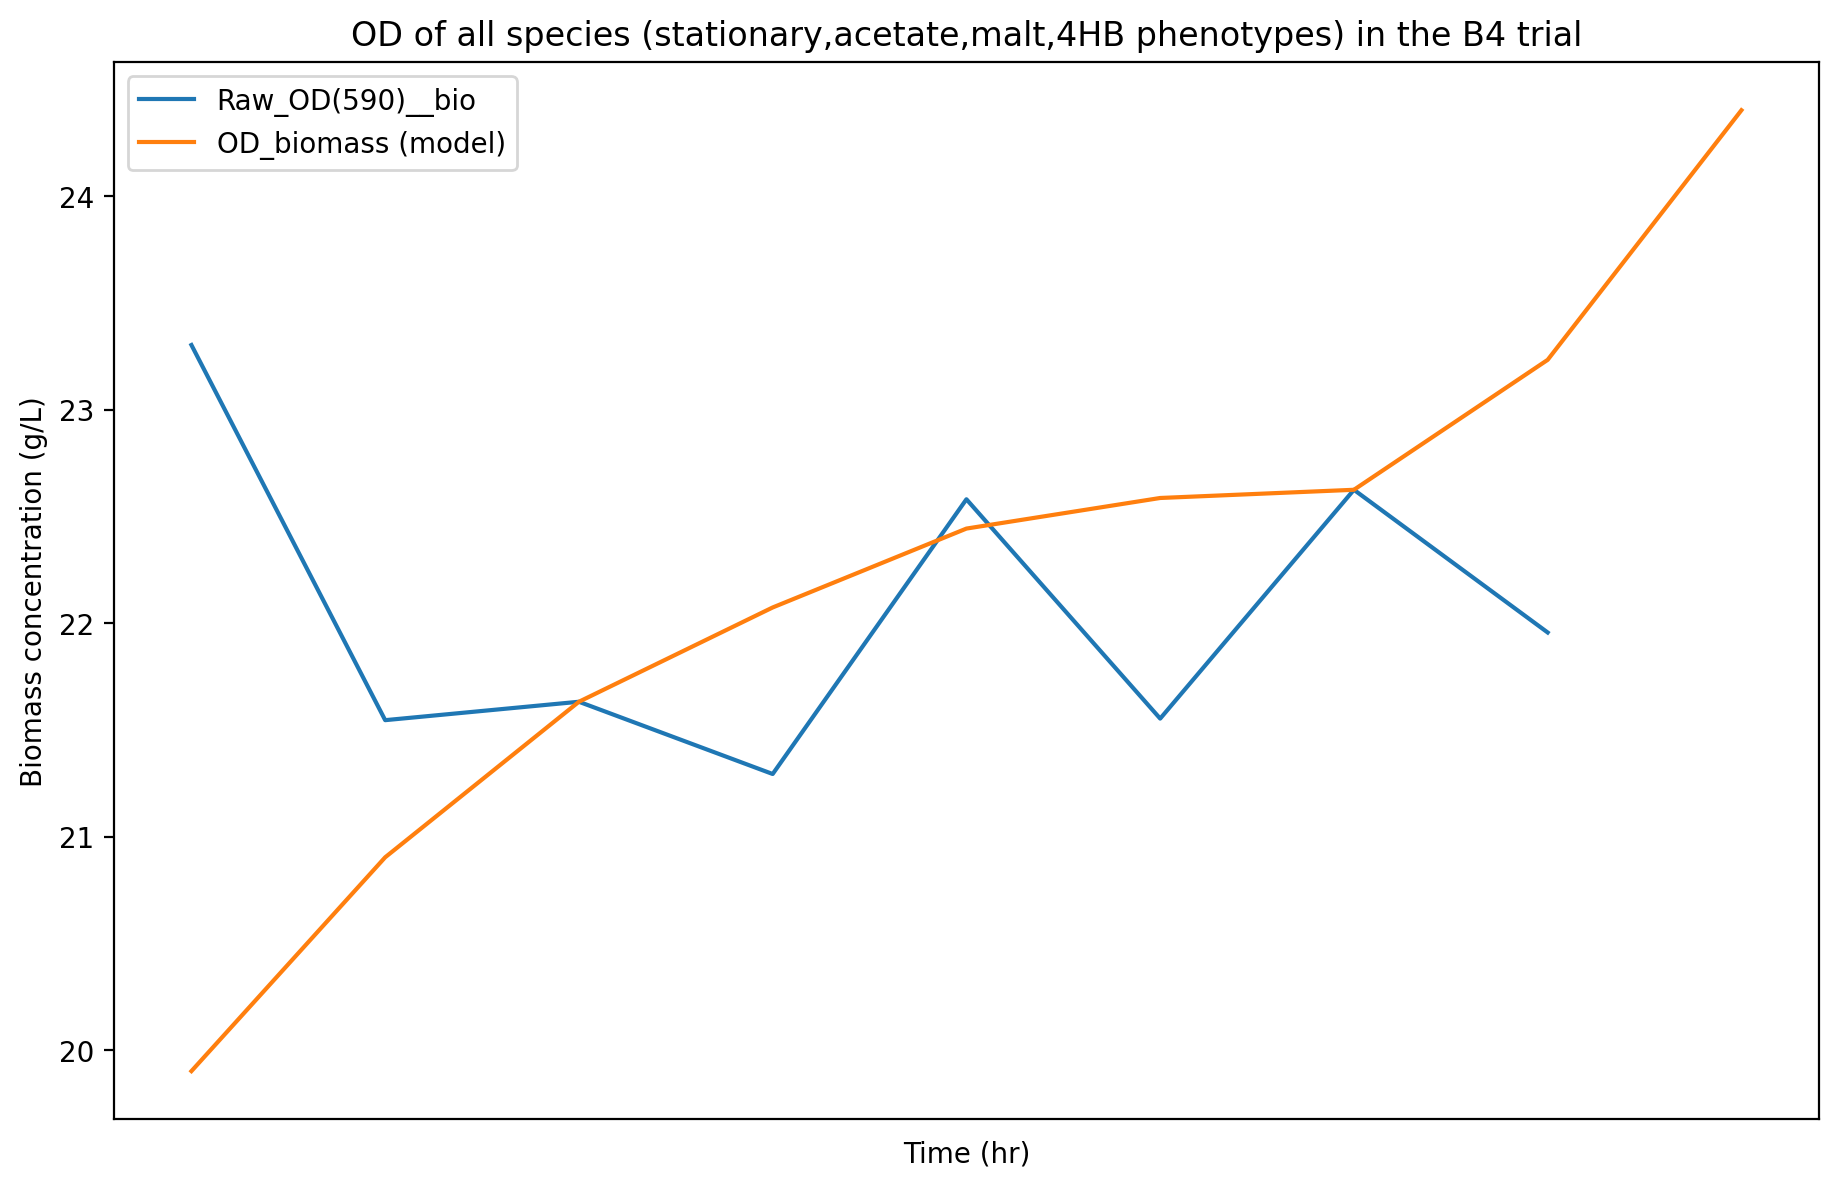

In [2]:
from datetime import datetime
from time import process_time
from pandas import set_option
set_option("display.max_rows", None)
# import the KBase objects
graphs = [
    {
        'trial':'B4',
        'content': 'OD',
        'experimental_data': True
    }
]

%run MSCommFitting.py
time1 = process_time()
mscommfit = MSCommFitting()
mscommfit.load_data(#phenotypes_csv_path = 'PhenotypeStoichiometry.csv', 
                    community_members = {
                        kbase_api.get_from_ws("iML1515",76994): {
                            'name': 'ecoli', 
                            'phenotypes': {#'acetate': kbase_api.get_from_ws('93465/13/1'), 
                                        'malt': {"cpd00179":[-1,-1]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                            }
                        },
                        kbase_api.get_from_ws("iSB1139.kb.gf",30650): {
                            'name': 'pf',
                            'phenotypes': {'acetate': {"cpd00029":[-1,-1]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4HB': {"cpd00136":[-1,-1]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                            }
                        }
                    },
                    base_media = kbase_api.get_from_ws("93465/19/1"),
                    signal_csv_paths = {'path':'data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx', 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                    carbon_conc_series = {'rows': {
                        'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
                        'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
                        }},
                    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,5,6,7,8,9,10,11,12]}, # 'wells': ['C2', 'G3', 'C12']}
                   # ignore_timesteps = list(range(11,167)),
                    # zip_path='mscomfit.zip'
                   )
time2 = process_time()
print(datetime.today(), (time2-time1)/60, 'minutes later')
mscommfit.define_problem(parameters={
                                    'v':.3,
                                    'cvmin': 100,
                                    'bcv': 100,
                                    'diffpos': 100,
                                    'diffneg': 100
                                    }, 
                         # export_zip_name='for_michaelis_menten.zip', 
                         final_rel_c12_conc = 0.1, 
                         bad_data_timesteps = {"*":"10:"},
                         mets_to_track = ["cpd00179","cpd00029","cpd00136"],
                         zero_start=["cpd00029"])
print(datetime.today())
%time mscommfit.compute(graphs) #, zip_name='simple_full_community.zip')
print('growth Vmax:', mscommfit.parameters['v'], 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

## Change the parameters

### crude, universal, Vmax

Done loading the JSON: 0.0010416666666666667 min
initial_concentrations 0
initial_concentrations 0
initial_concentrations 5


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'mscommfitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the model: 0.019791666666666666 min
Done loading the model: 0.09010416666666667 min
graph_0
{'content': 'OD',
 'experimental_data': True,
 'phenotype': {'malt', '4HB', 'stationary', 'acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'B4'}
experimental_data


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'primal_values.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


CPU times: total: 297 ms
Wall time: 344 ms
2022-09-21 20:40:15.071594
growth Vmax: 0.1 objective value: 20809.069341316244 




Done loading the JSON: 0.0010416666666666667 min
initial_concentrations 0
initial_concentrations 0
initial_concentrations 5
Done exporting the model: 0.019791666666666666 min
Done loading the model: 0.0859375 min
graph_0
{'content': 'OD',
 'experimental_data': True,
 'phenotype': {'malt', '4HB', 'stationary', 'acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'B4'}
experimental_data
CPU times: total: 406 ms
Wall time: 431 ms
2022-09-21 20:40:21.957557
growth Vmax: 0.13333333333333336 objective value: 10654.35273284174 






C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'B4_all species_malt,4HB,stationary,acetate phenotypes_OD.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done loading the JSON: 0.0018229166666666667 min
initial_concentrations 0
initial_concentrations 0
initial_concentrations 5
Done exporting the model: 0.0203125 min
Done loading the model: 0.08828125 min
graph_0
{'content': 'OD',
 'experimental_data': True,
 'phenotype': {'malt', '4HB', 'stationary', 'acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'B4'}
experimental_data
CPU times: total: 422 ms
Wall time: 445 ms
2022-09-21 20:40:29.042554
growth Vmax: 0.16666666666666669 objective value: 5543.02349223636 




Done loading the JSON: 0.0010416666666666667 min
initial_concentrations 0
initial_concentrations 0
initial_concentrations 5
Done exporting the model: 0.0203125 min
Done loading the model: 0.09166666666666666 min
graph_0
{'content': 'OD',
 'experimental_data': True,
 'phenotype': {'malt', '4HB', 'stationary', 'acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'B4'}
experimental_data
CPU times: total: 516 ms
Wall time: 550 ms
2022-09-21 20:40:36.498495
growth Vmax: 0.

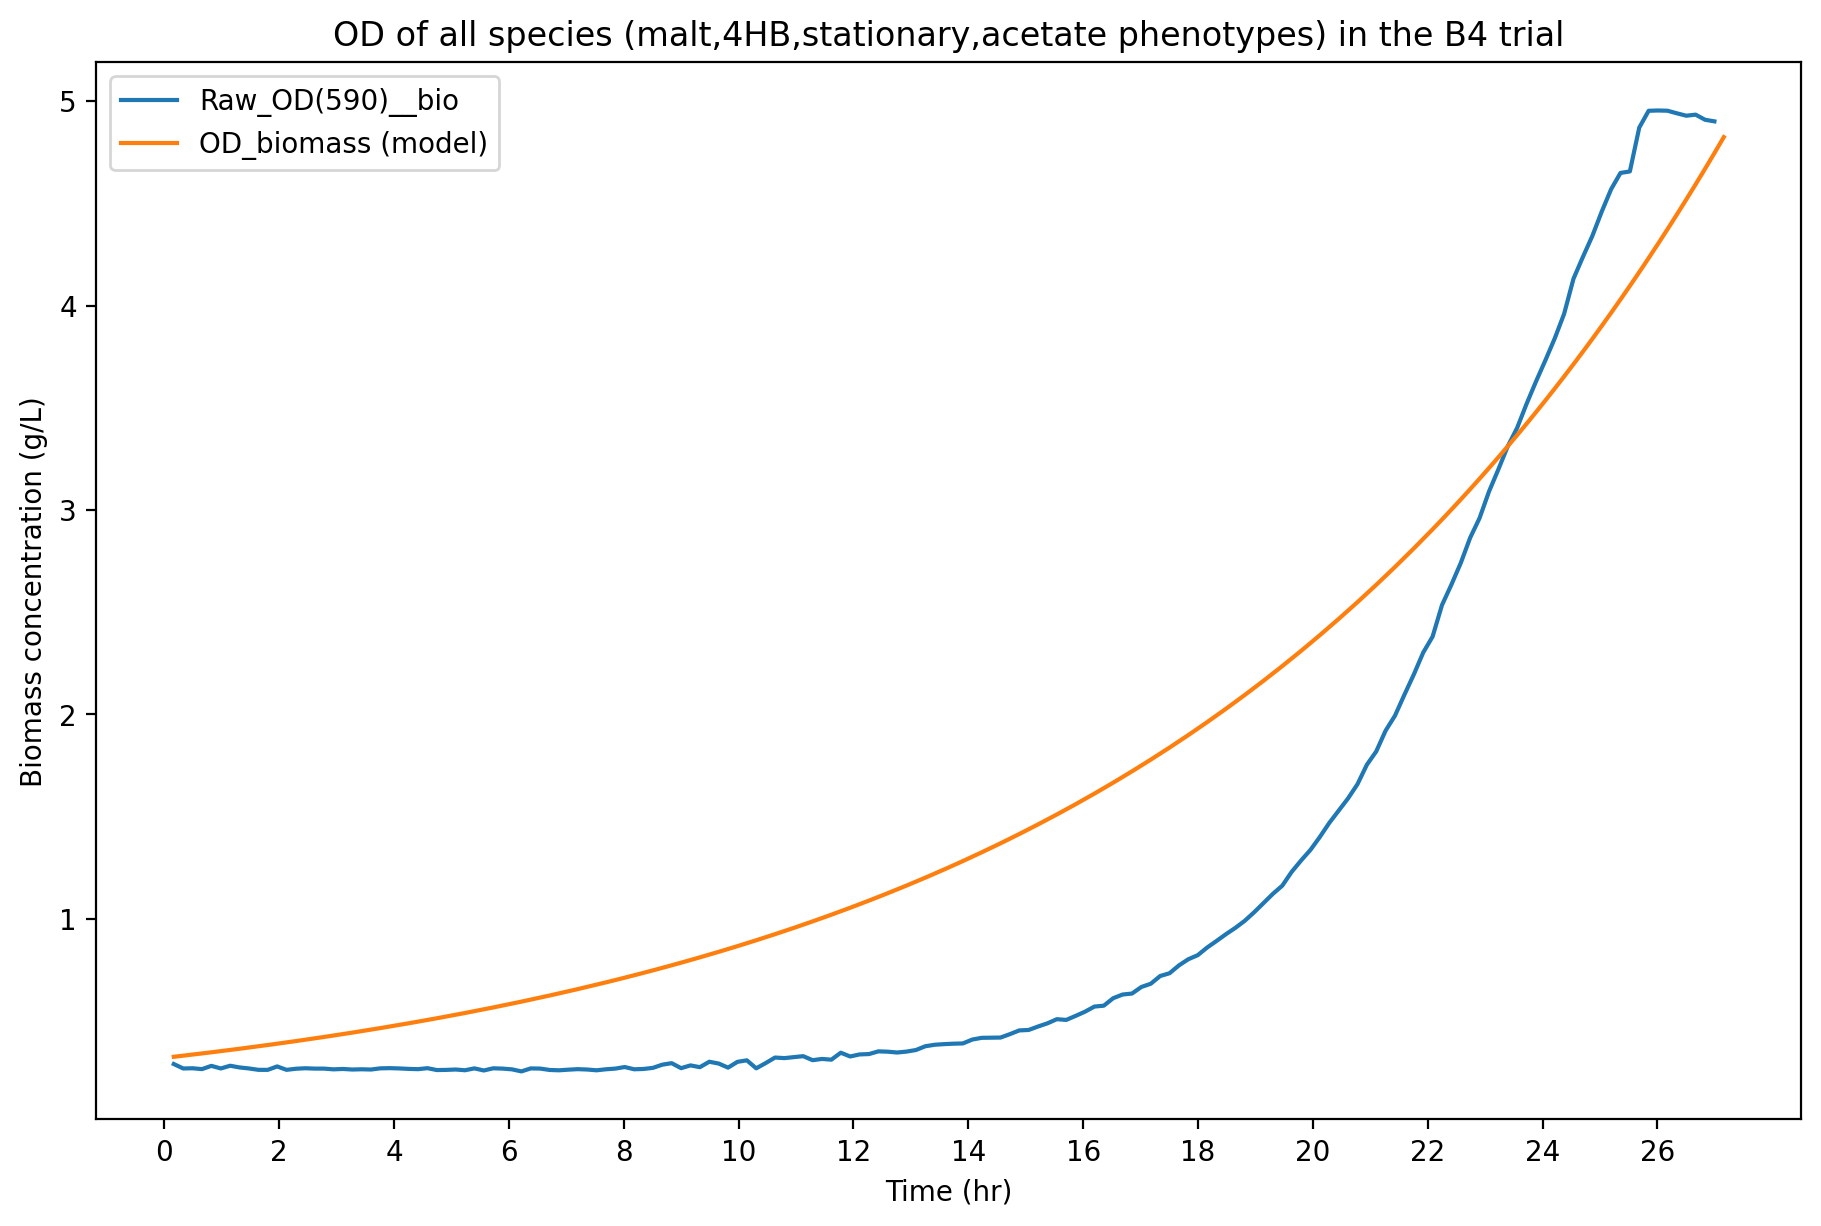

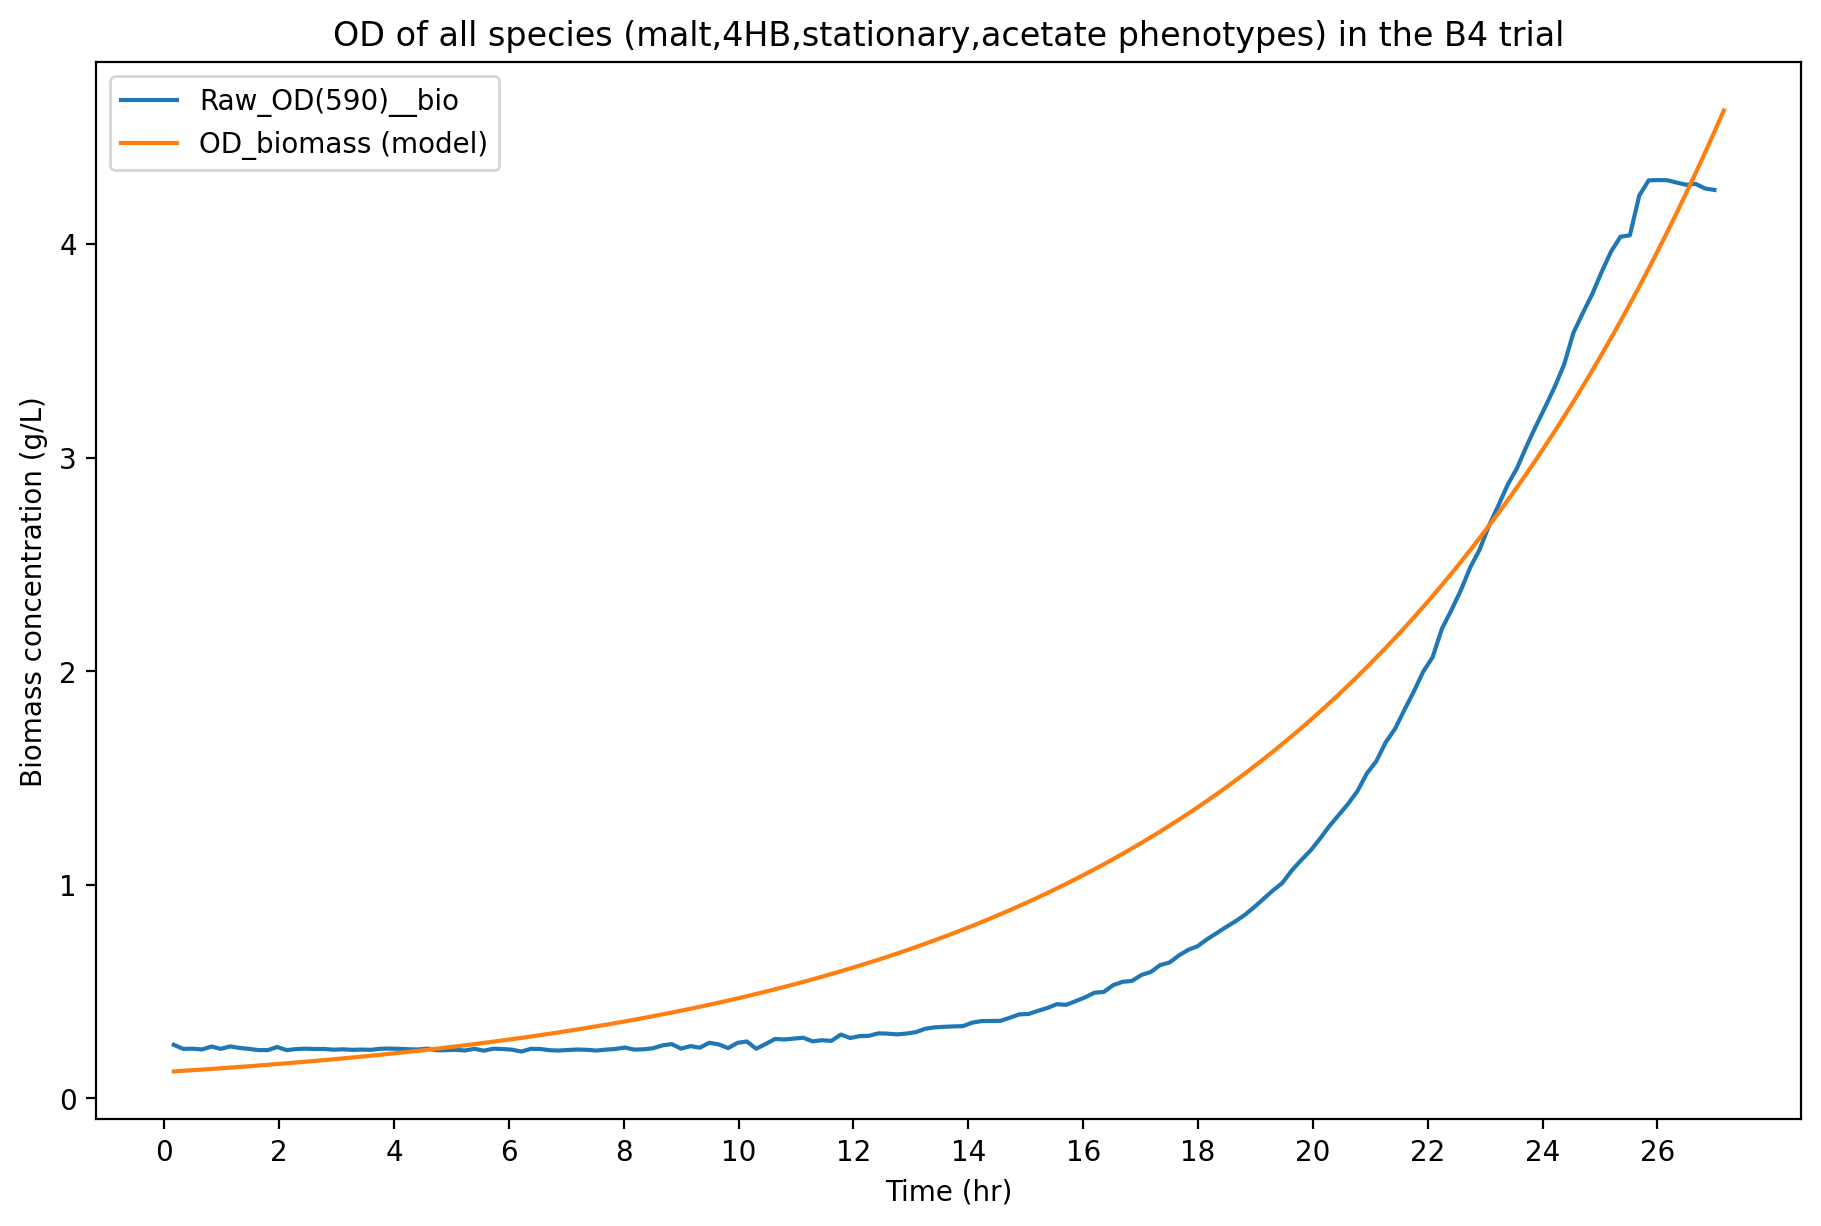

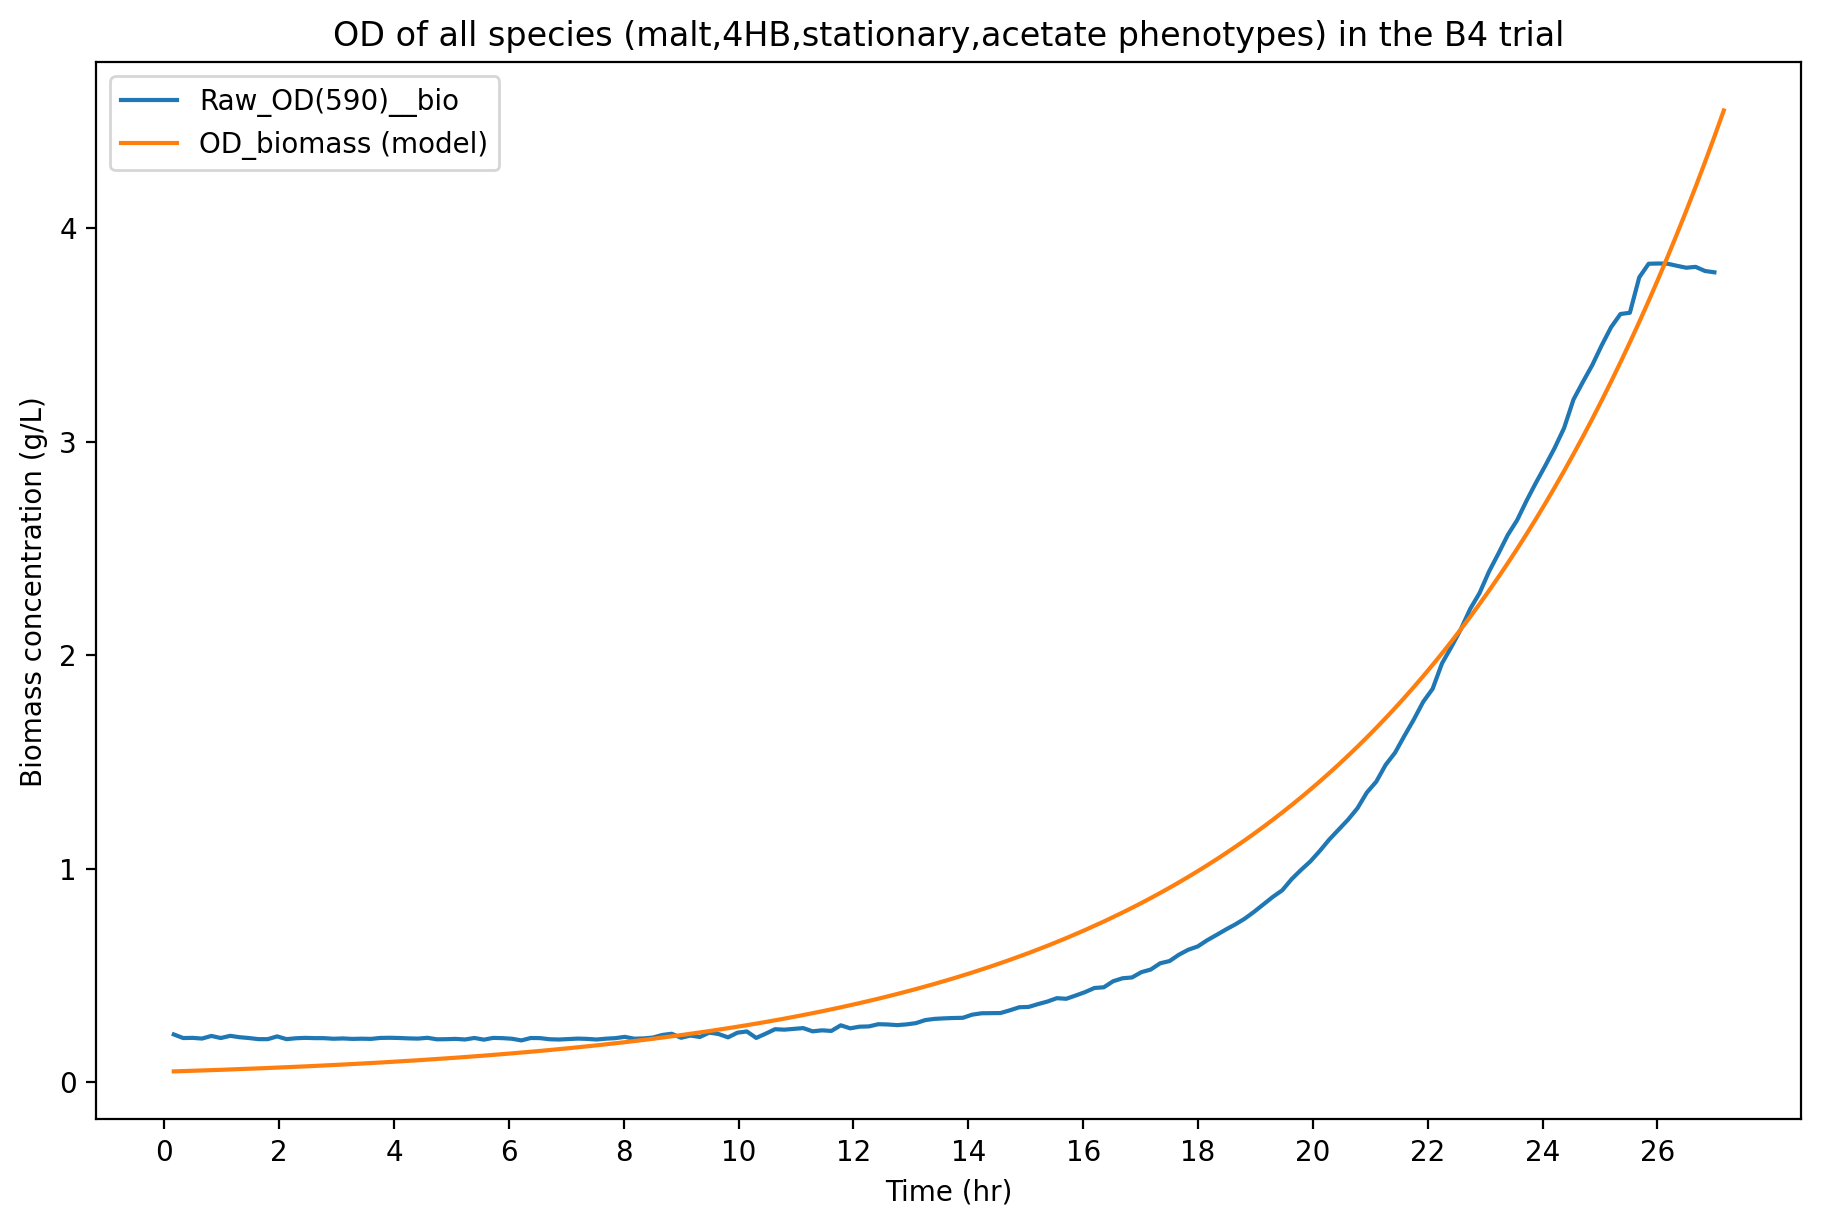

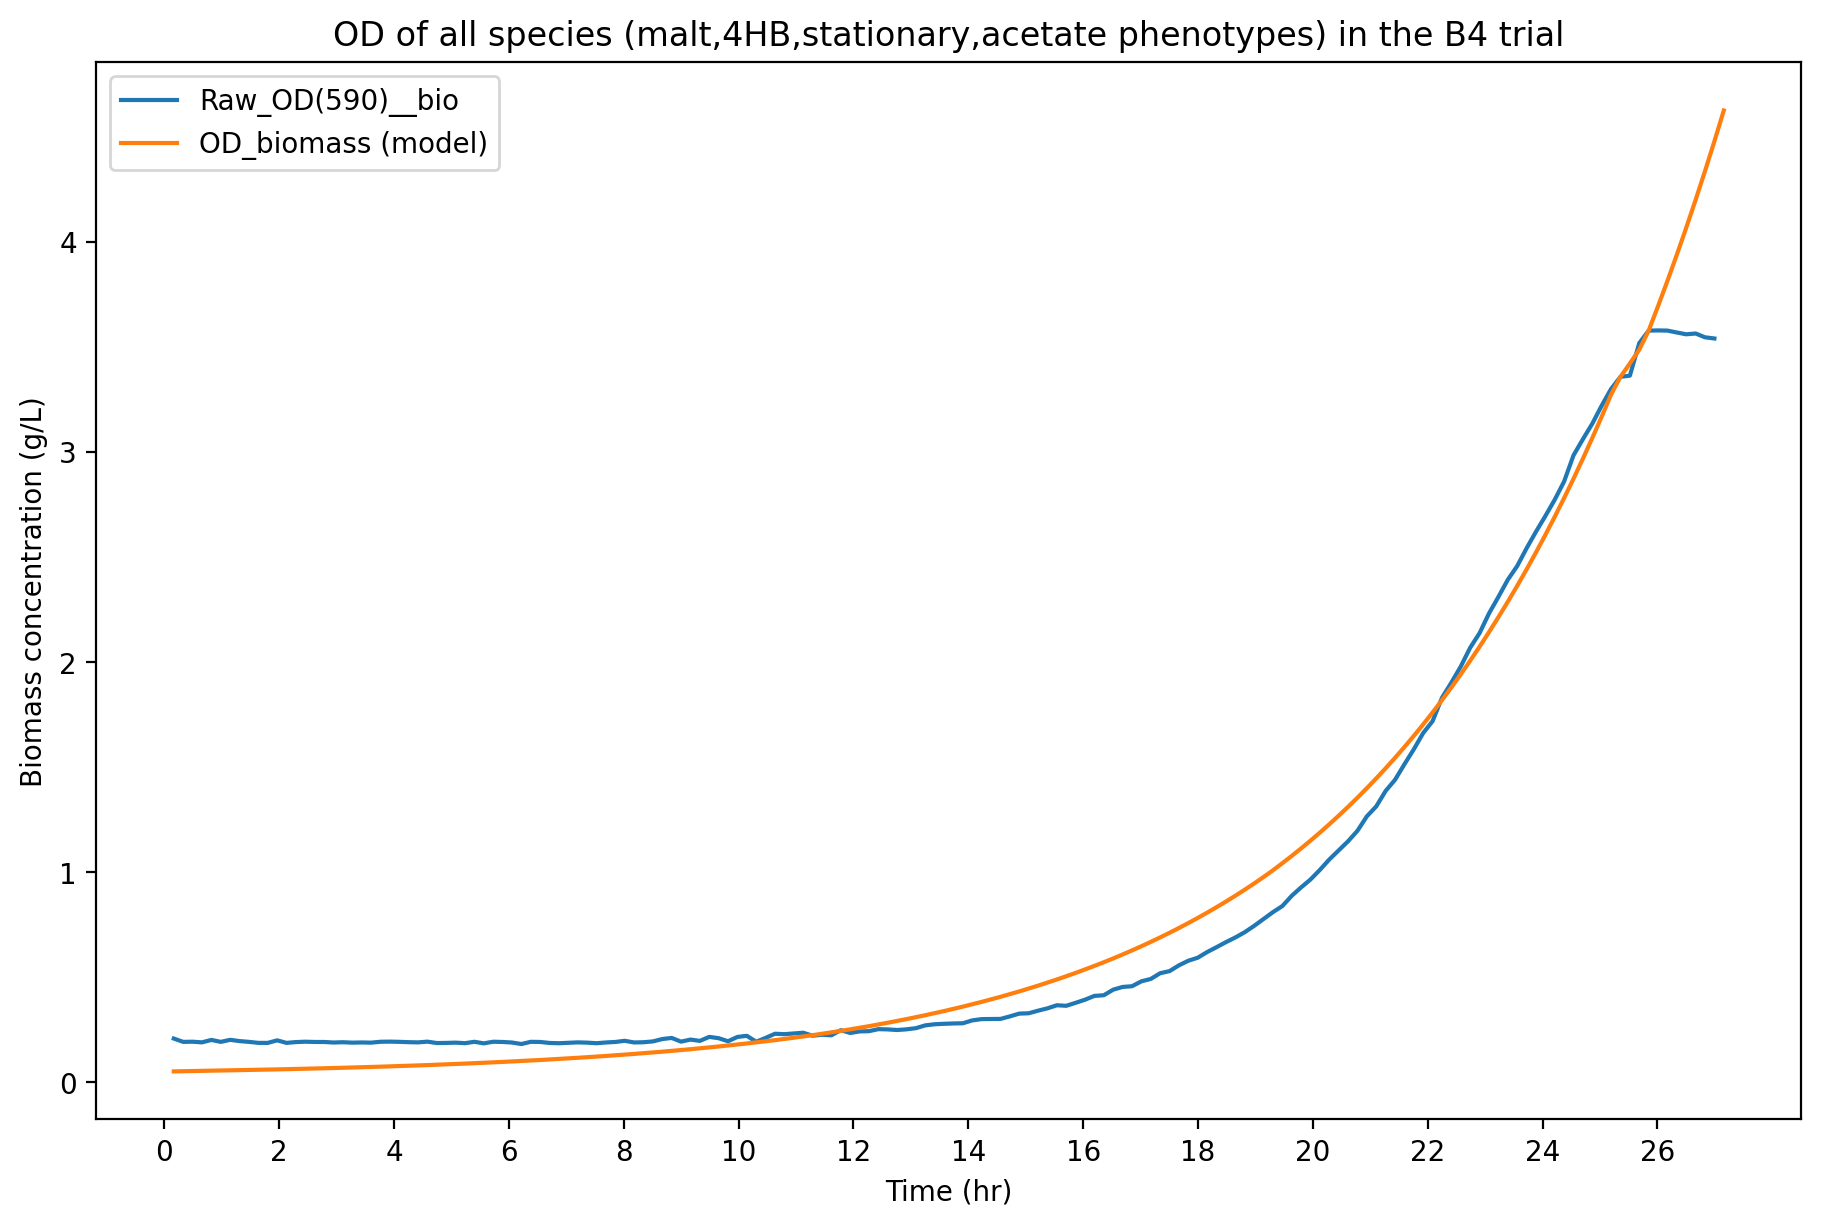

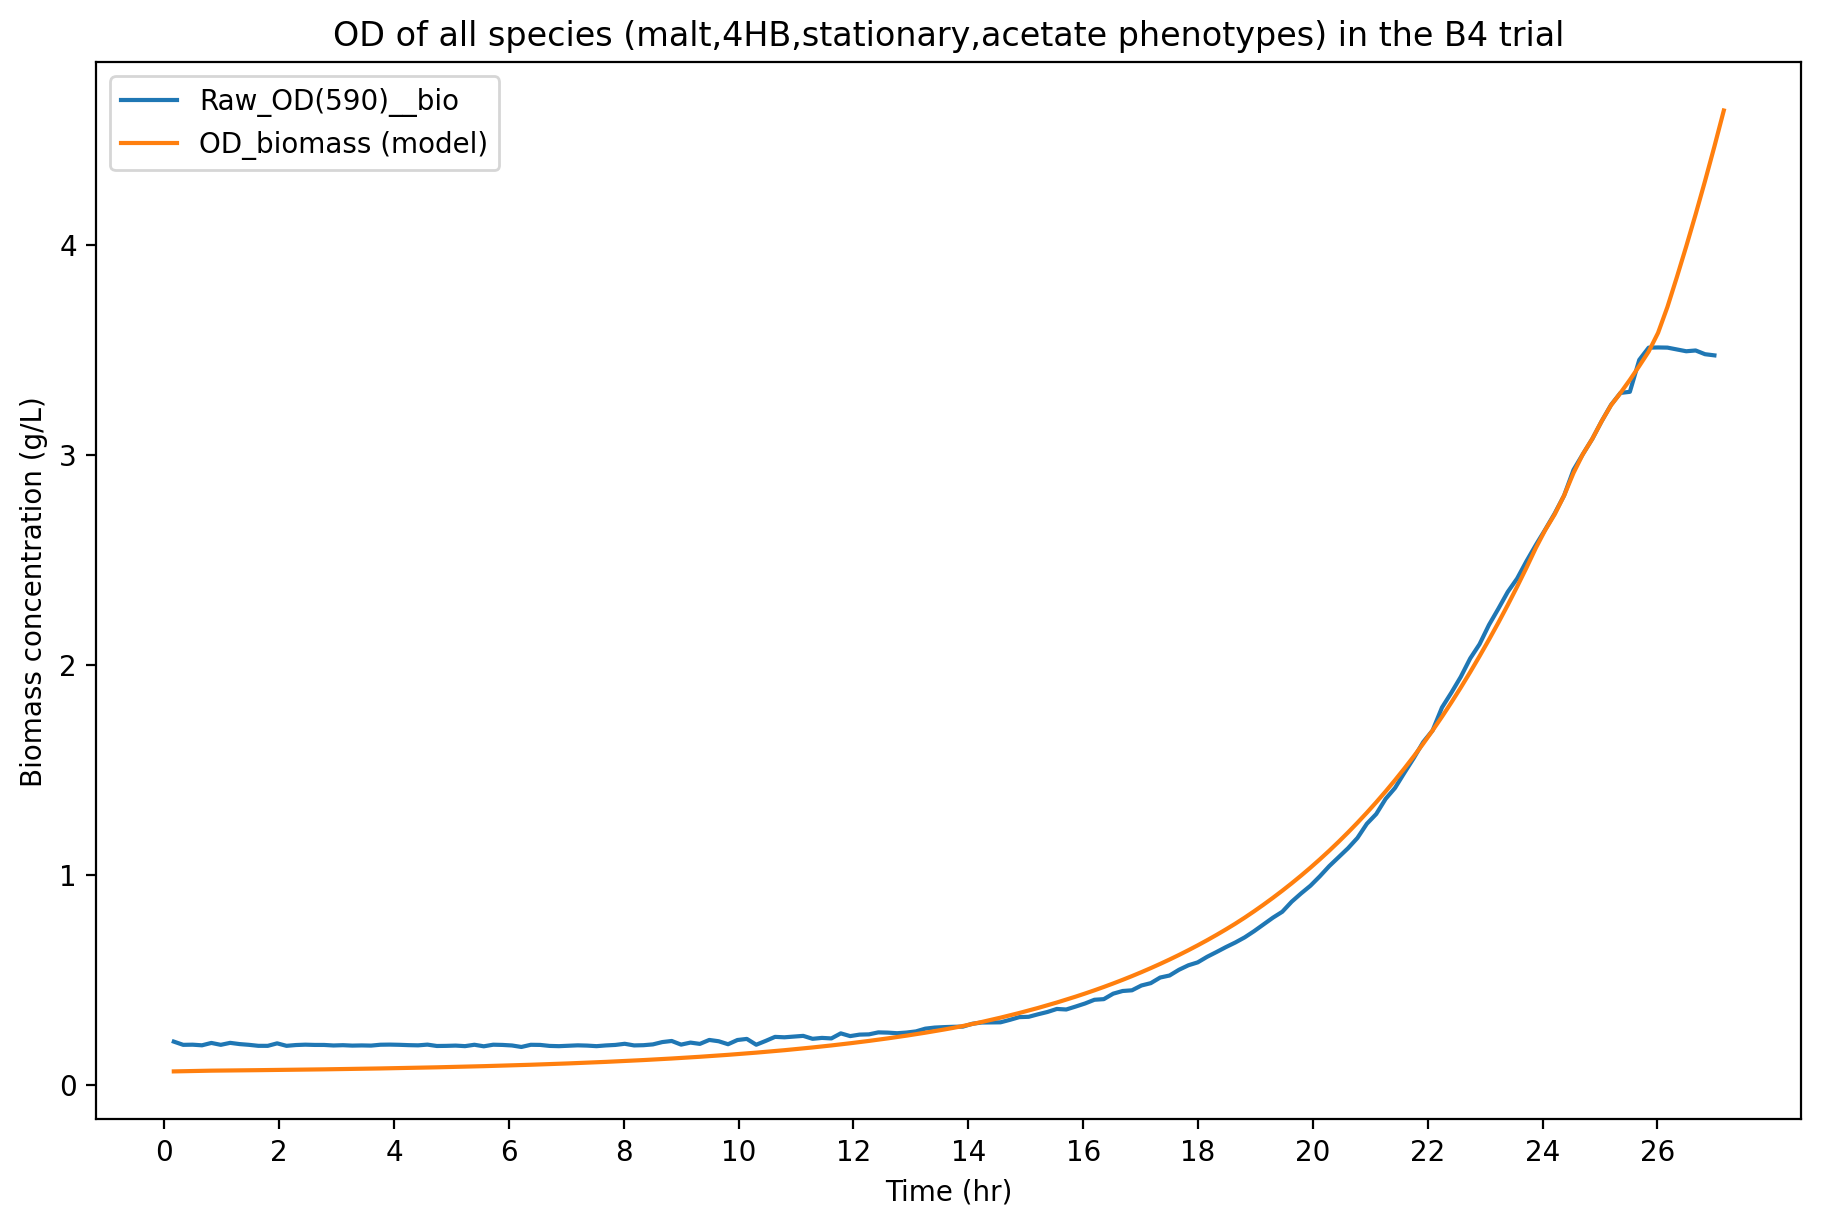

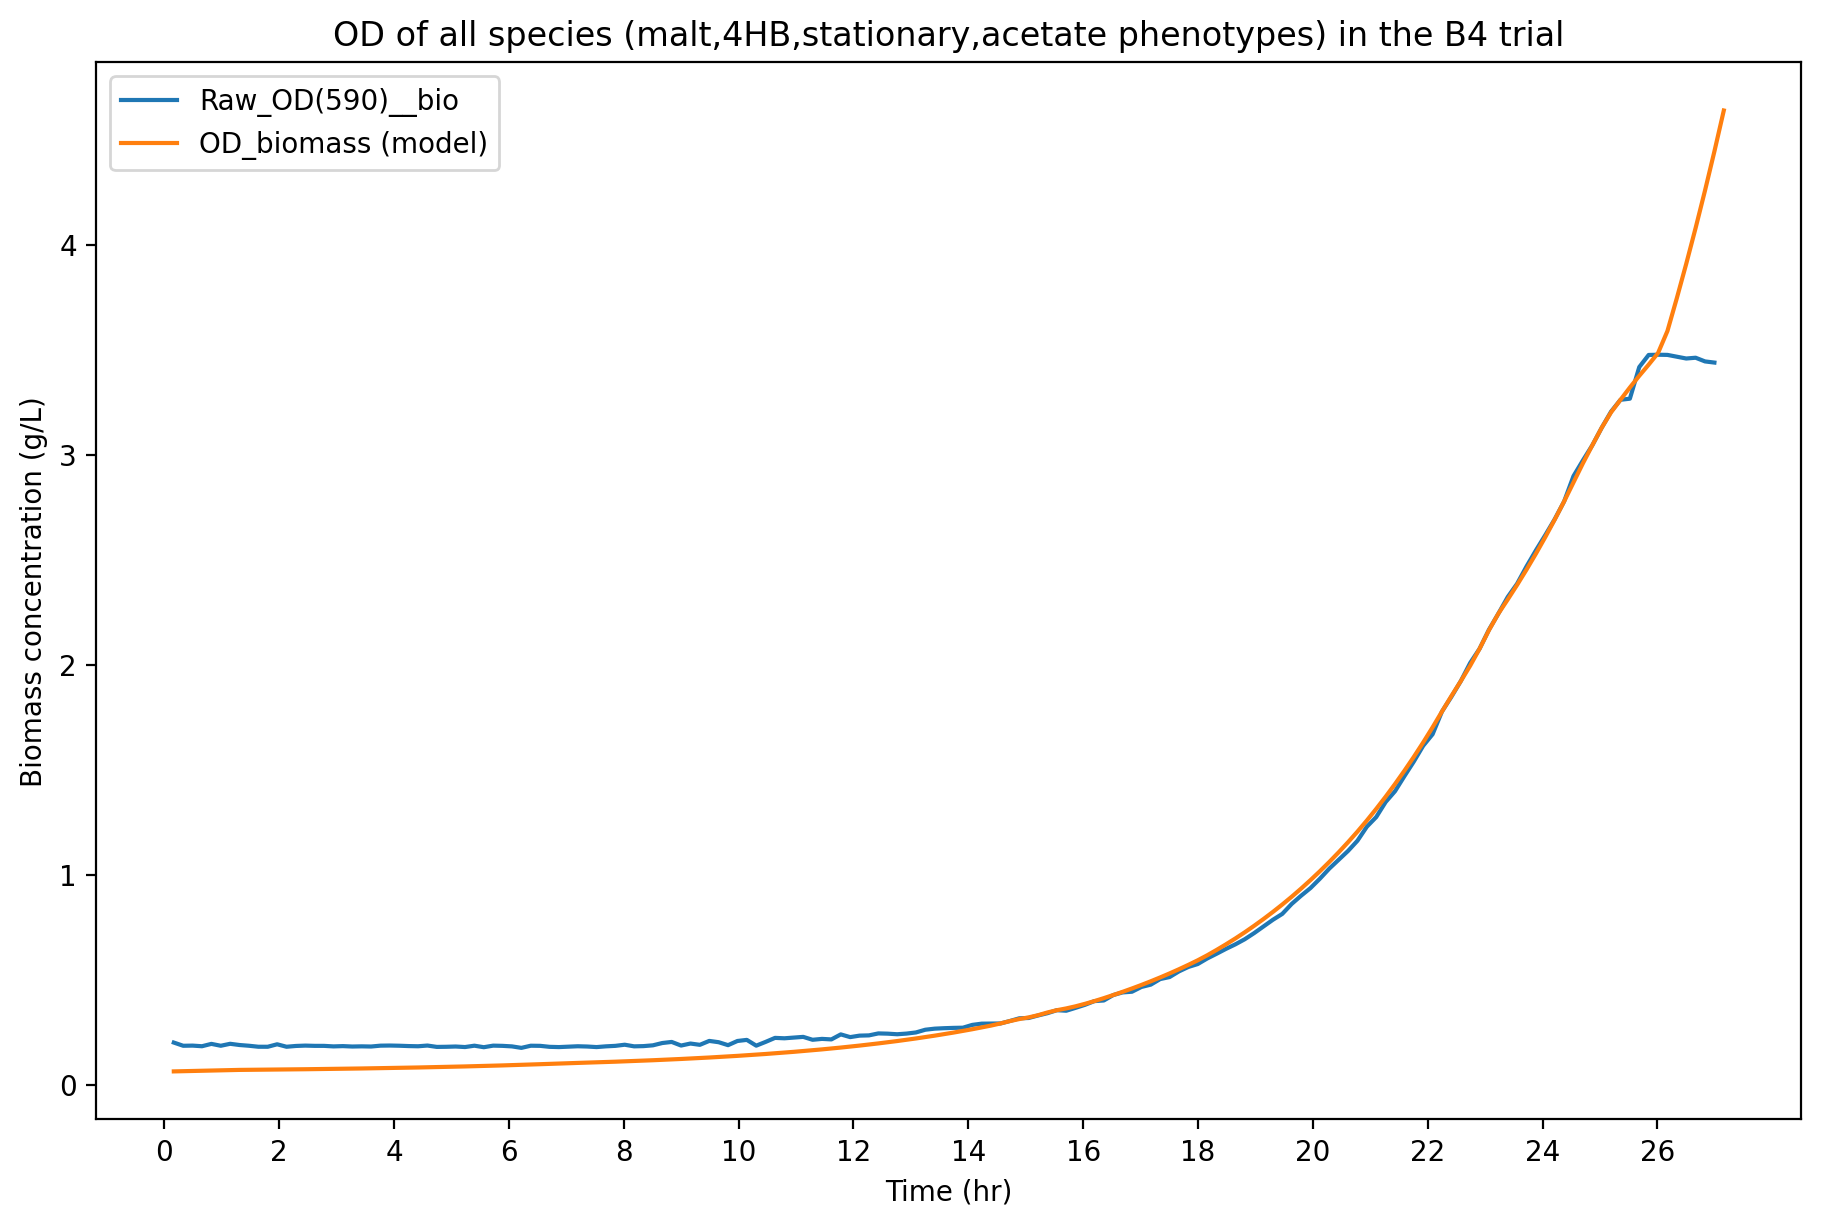

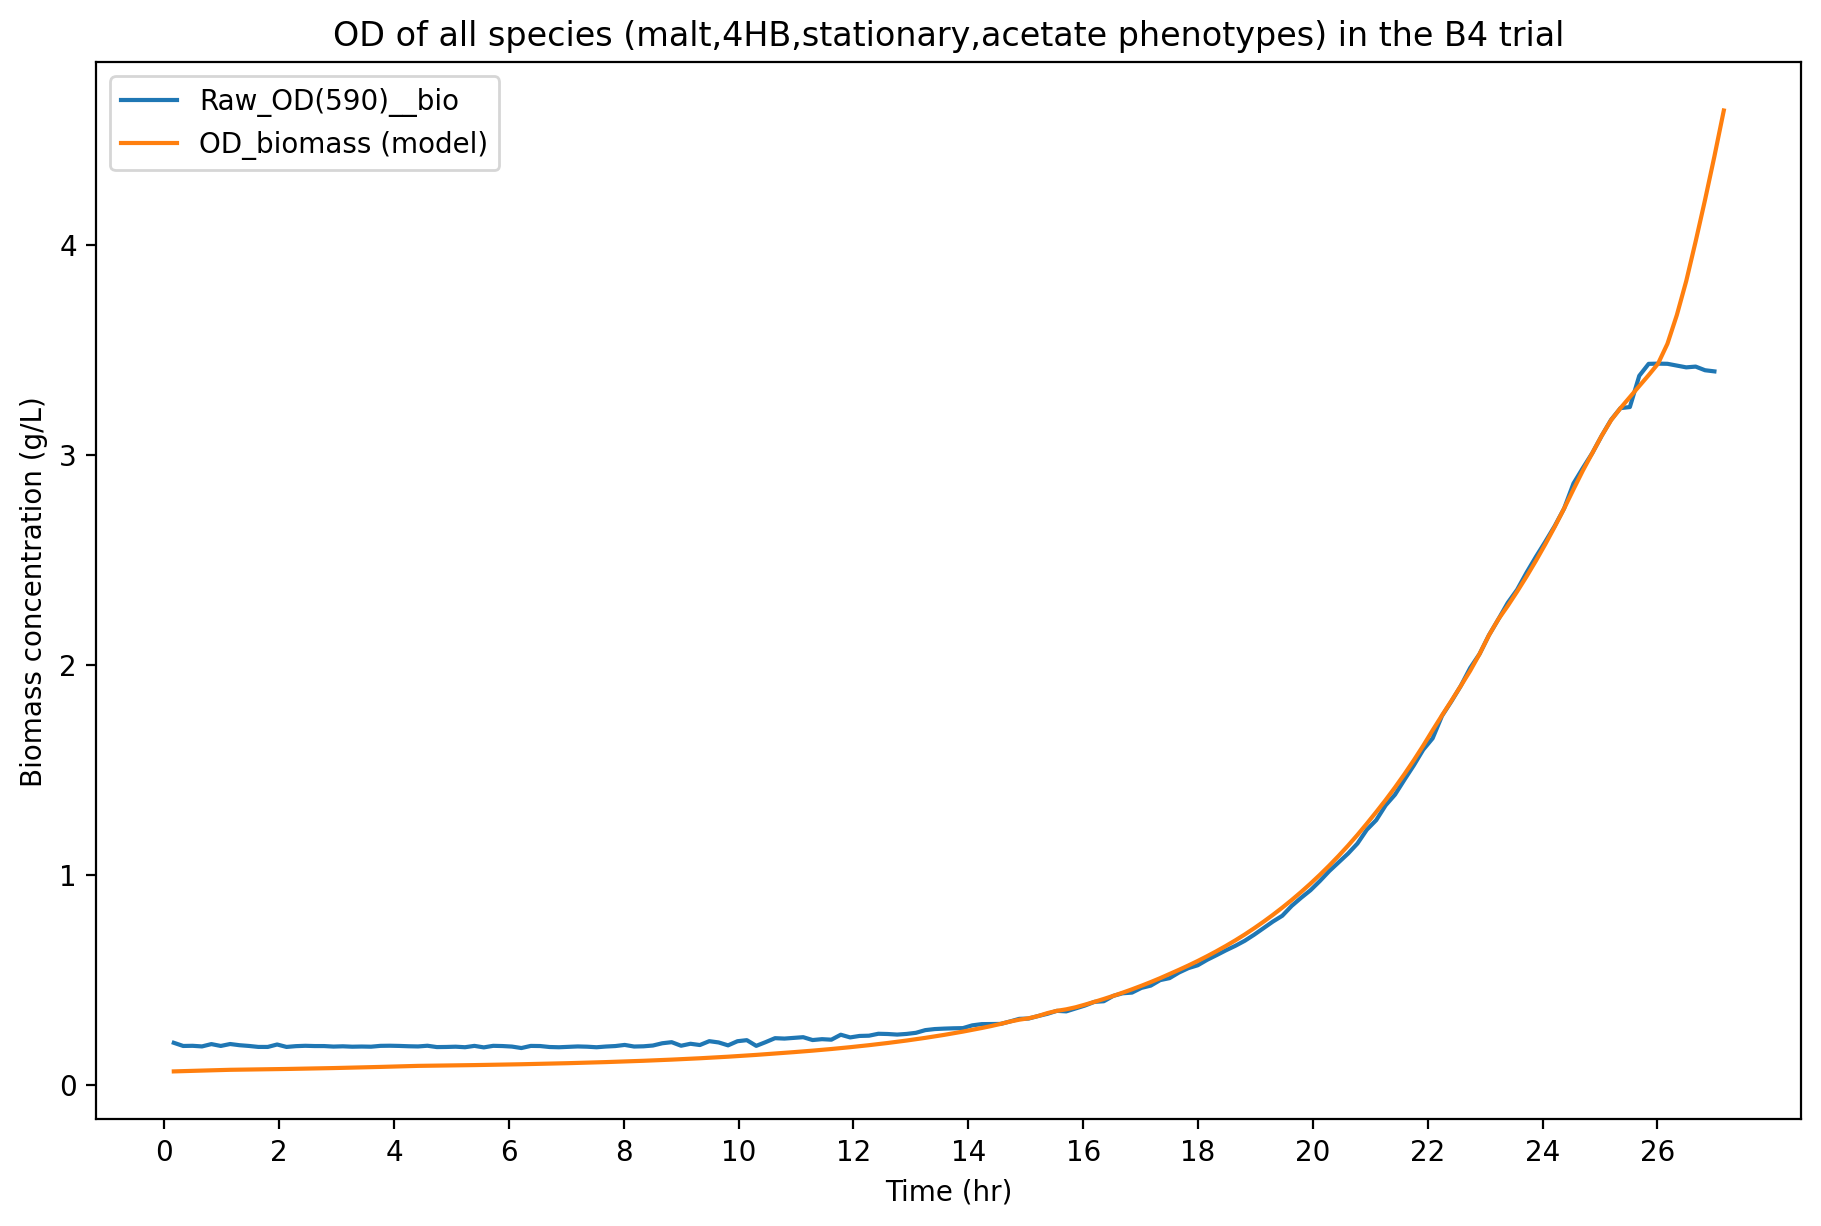

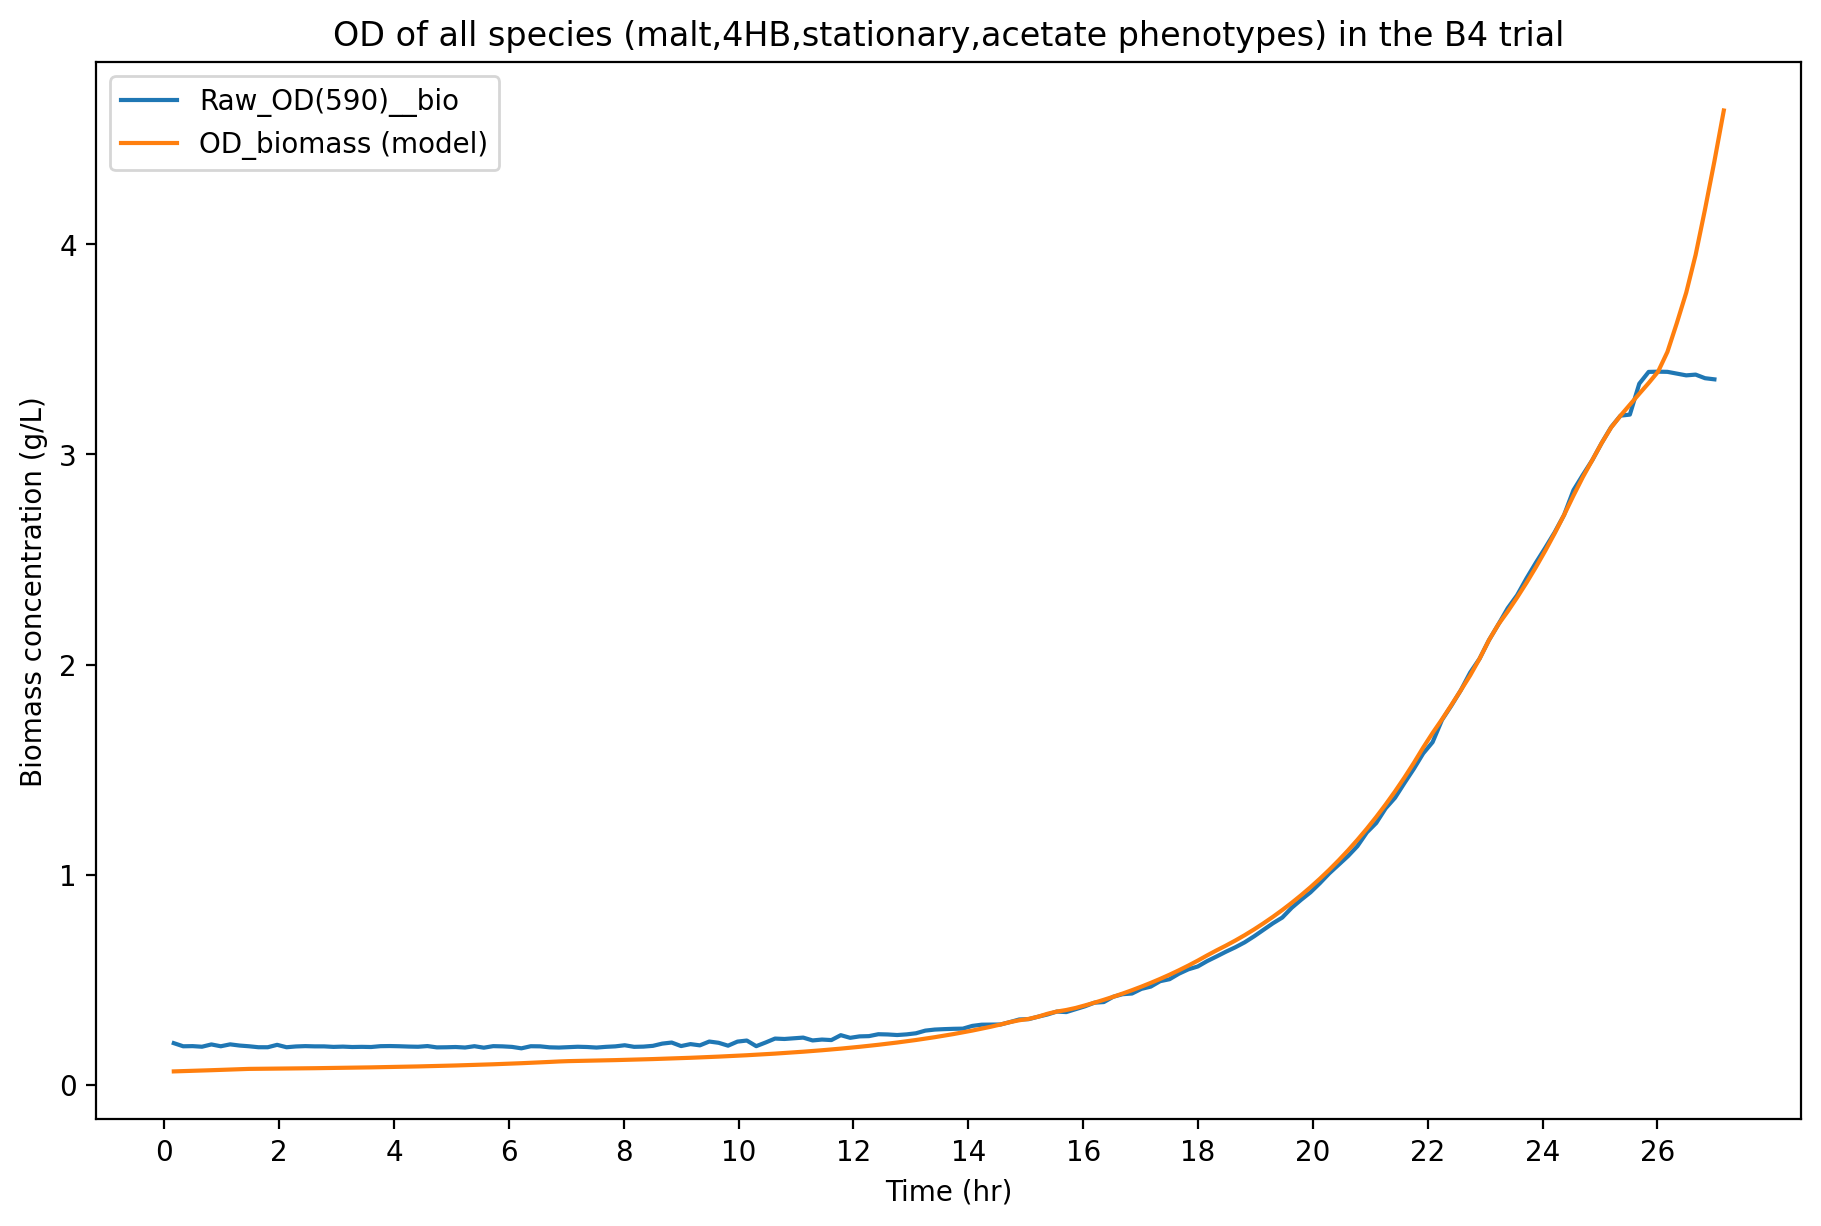

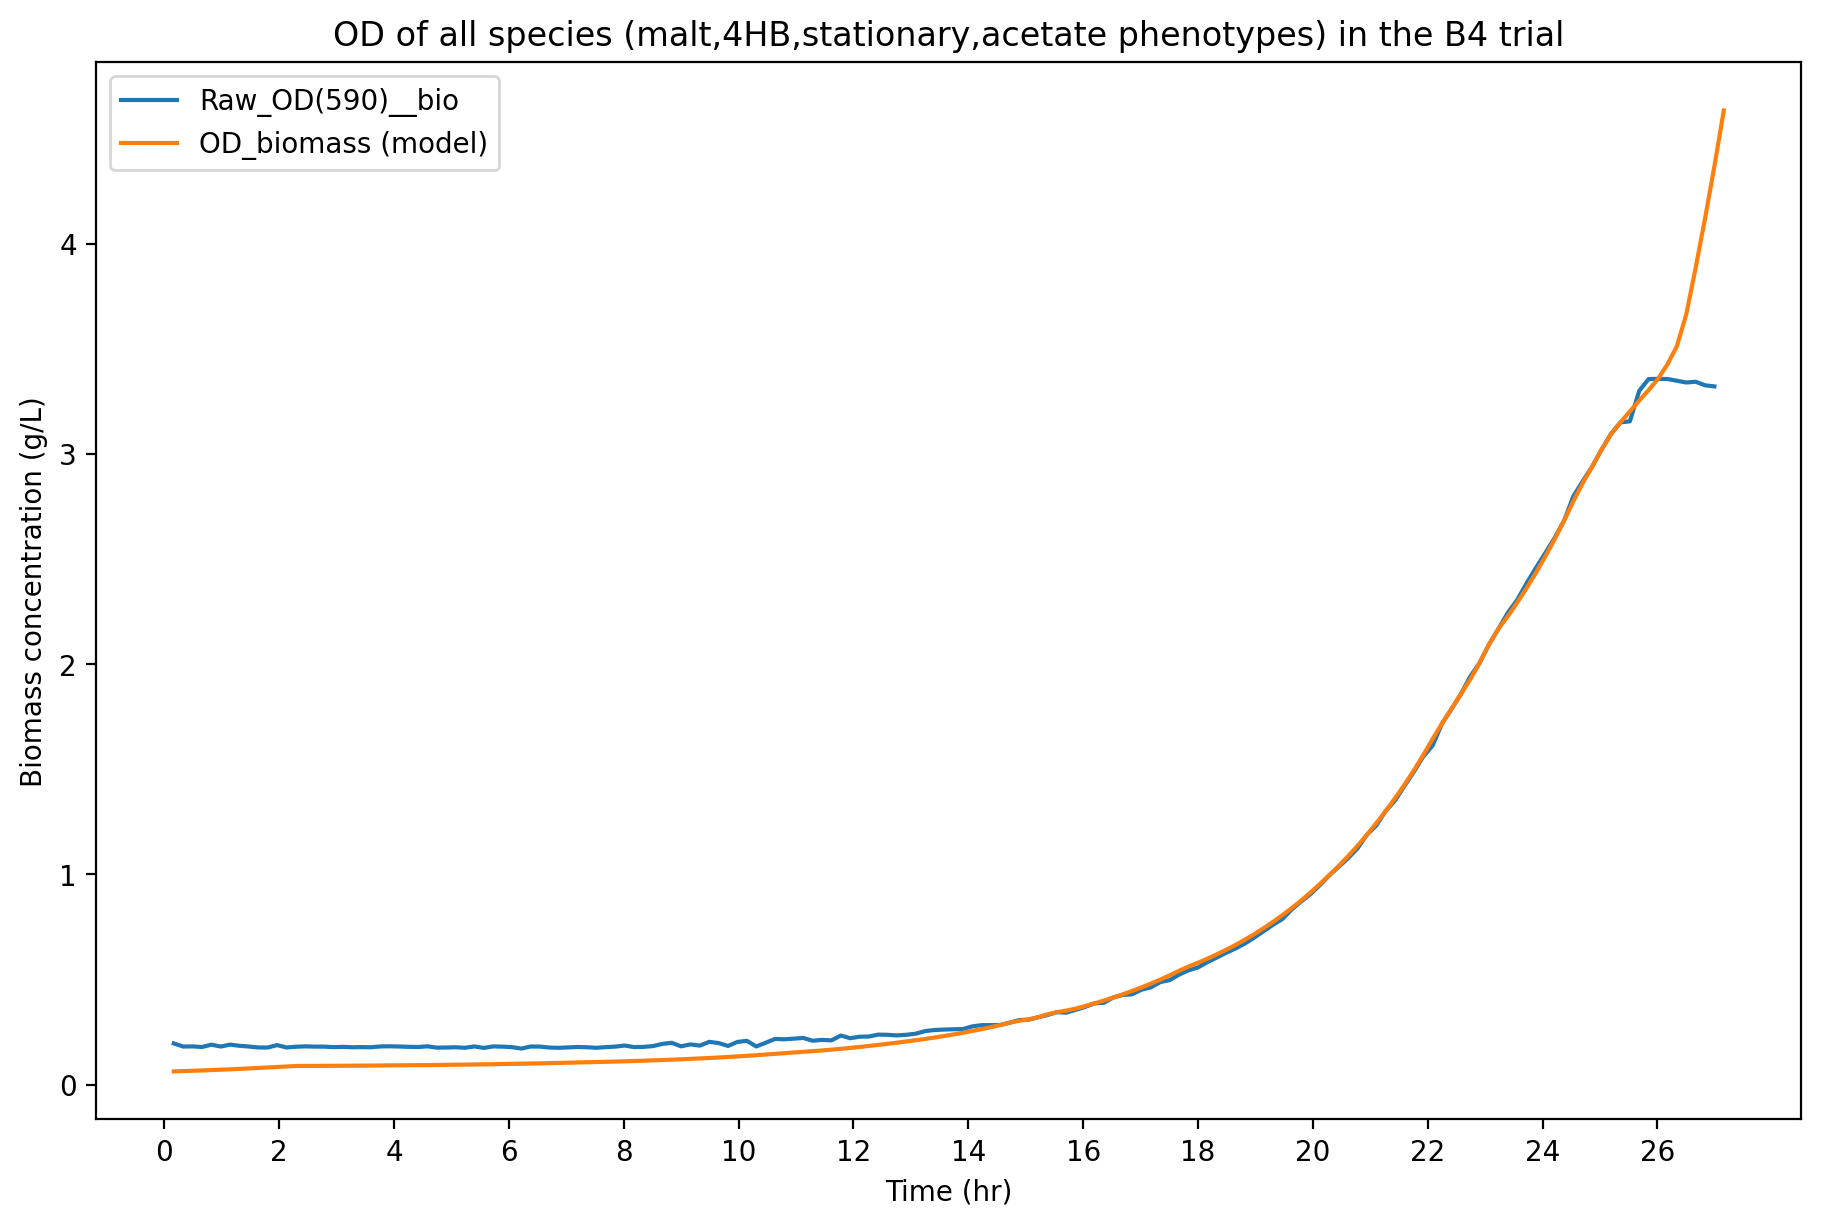

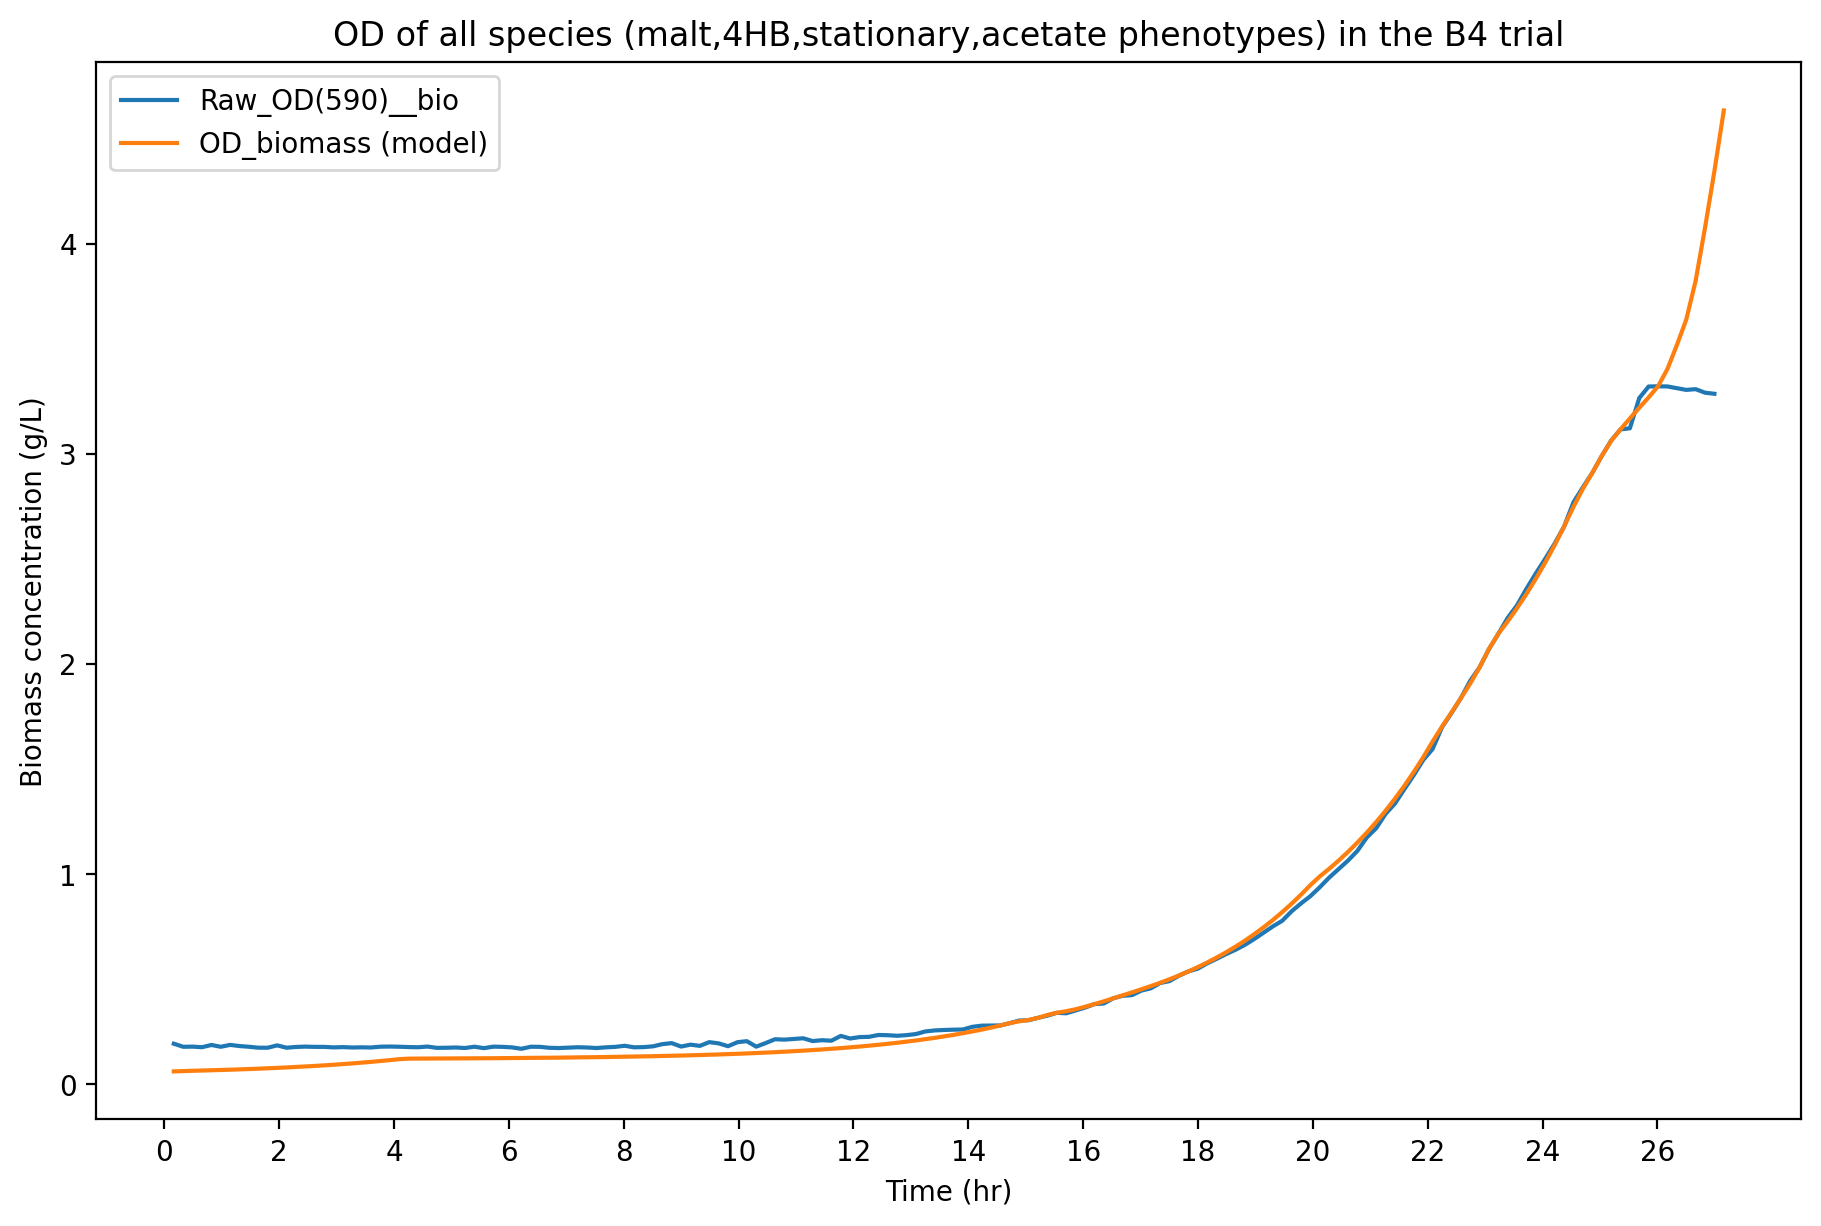

In [3]:
from itertools import chain
from numpy import linspace

interesting_metabolites = list(chain(*mscommfit.phenotype_met.values()))

for vmax in linspace(.1,.4,10):
    mscommfit.change_parameters(vmax={met:-vmax for met in interesting_metabolites}, export_zip_name='michaelis_menten_edited.zip', extract_zip_name='for_michaelis_menten.zip')
    %time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
    print(datetime.today())
    print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

### specified trial-time dependent Vmax

In [4]:
from numpy import linspace

vmax_values = {}
km_values = {}
for var, content in mscommfit.variables.items():
    if isinstance(var, dict):
        for time in content.keys():
            vmax_values[time] = {trial:2.2667 for trial in content2}
            km_values[time] = {trial:2 for trial in content2}

mscommfit.change_parameters(vmax=vmax_values, km=km_values, strain='ecoli_malt', graphs=graphs, export_zip_name='simple_full_community_edited.zip', extract_zip_name='simple_full_community.zip')
%time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
print(datetime.today())
print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

TypeError: change_parameters() got an unexpected keyword argument 'strain'

### Km variability with a constant Vmax

In [3]:
from itertools import chain
from numpy import linspace

interesting_metabolites = list(chain(*mscommfit.phenotype_met.values()))
# Vmax=0.42 & Km=2 to start, given [maltose]=5, which yields 0.3
vmax = 0.42
for km in linspace(1.5,2.5,10):
    mscommfit.change_parameters(vmax={met:vmax for met in interesting_metabolites}, km={met:km for met in interesting_metabolites}, export_zip_name='michaelis_menten_edited.zip', extract_zip_name='for_michaelis_menten.zip')
    %time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
    print(datetime.today())
    print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

Done loading the JSON: 0.0010416666666666667 min
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new concentration 0.0
new growth rate:  -0.0
new co

FeasibilityError: The solution is sub-optimal, with a infeasible status.

In [7]:
base_media = kbase_api.get_from_ws("93465/19/1")
print(dir(base_media), base_media.path)

['__VERSION__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_from_json', '_to_json', '_to_object', 'copied', 'copy_source_inaccessible', 'created', 'creator', 'data', 'data_keys', 'epoch', 'exclude_dict', 'get_data', 'get_kbase_args', 'get_media_constraints', 'id', 'info', 'isDefined', 'isMinimal', 'mediacompounds', 'name', 'orig_wsid', 'path', 'provenance', 'reagents', 'refs', 'source_id', 'type'] ['93465/19/1']


# First-phase optimization (alternatively solving for v and b)

In [ ]:
# import the models
from cobra.io import load_json_model
ecoli = load_json_model("ecoli.json")
pf = load_json_model("pf.json")
# print(ecoli.optimize())
# print(pf.optimize())

# load the media
import os
# local_cobrakbase_path = os.path.join('/Users/afreiburger/Documents')
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path
import cobrakbase
# with open("/Users/afreiburger/Documents/kbase_token.txt") as token_file:
with open("C:/Users/Andrew Freiburger/Documents/Argonne/kbase_token.txt") as token_file:
    kbase_api = cobrakbase.KBaseAPI(token_file.readline())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        "species":["ecoli"],
        'content': 'biomass'
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial, conc):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

cobrakbase 0.2.8


In [ ]:
%run ./data/standardized_data/datastandardization.py
growth_data_path="data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, signal_species, trial_name_conversion, species_phenos_df, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = {
        1:{"ecoli":0, "pf":1},
        2:{"ecoli":1, "pf":50},
        3:{"ecoli":1, "pf":20},
        4:{"ecoli":1, "pf":10},
        5:{"ecoli":1, "pf":3},
        6:{"ecoli":1, "pf":1},
        7:{"ecoli":3, "pf":1},
        8:{"ecoli":10, "pf":1},
        9:{"ecoli":20, "pf":1},
        10:{"ecoli":1, "pf":0},
        11:{"ecoli":0, "pf":0}
      },
    carbon_conc_series = {'rows': {
        'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
        'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    }},
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,6,7,8,9,10,11,12]},
    # ignore_timesteps="10:",  # The 
    species_identities_rows = {
        1:{"ecoli":"mRuby"},
        2:{"ecoli":"ACS"},
        3:{"ecoli":"mRuby"},
        4:{"ecoli":"ACS"},
        5:{"ecoli":"mRuby"},
        6:{"ecoli":"ACS"}
    }
)
print(f"{(process_time()-time1)/60} minutes")

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\data\standardized_data\datastandardization.py:109: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


-3.0698514492030666
-0.48914864782284867
-3.0636144602420945
The model GCF_001612705.1.RAST.mdl is unable to be simulated with pFBA and yields a < None (infeasible). > error.
-1.347830069517247
The ['B2', 'B3', 'B4', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.25743282 1.25756953 1.25646515 1.25160708 1.25131364 1.24656429
 1.23908944 1.24441001 1.24179058 1.23174872 1.2387953  1.23445973
 1.2314147  1.23049743 1.23039

In [13]:
display(maltose_4HB_commfit.growth_df)

,ecoli_acetate,ecoli_malt,ecoli_stationary,pf_acetate,pf_4HB,pf_stationary
mNeonGreen,0,0,0,1,1,1
mRuby,1,1,1,0,0,0


,trial_IDs,Time (s),Raw_OD(590),mNeonGreen,mRuby
short_codes,,,,,
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,1.074667,0.072886,22506.0,1353.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,597.208667,0.074226,22901.0,1370.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,1189.086667,0.068009,22250.0,1384.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,1781.571333,0.068349,22252.0,1411.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,2374.050667,0.067953,21821.0,1439.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,2966.571667,0.070851,22275.0,1347.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,3558.901667,0.067426,21742.0,1375.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,4151.333667,0.068058,21604.0,1422.0
G4,r1_ecoli_mRuby-r10_pf-5_ecoli,4743.744000,0.068703,21336.0,1428.0


C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:79: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.0013020833333333333 min
Done with DCC loop: 0.00026041666666666666 min
Done with the dbc & diffc loop: 0.0036458333333333334 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.10390625 min
Done exporting the content: 0.022916666666666665 min
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'phenotype': {'malt', '4HB', 'acetate', 'stationary'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G4'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00029'],
 'trial': 'G4'}
graph_2
{'content': 'biomass',
 'experimental_data': False,
 'phenotype': {'malt', 'acetate', 'stationary'},
 'species': ['ecoli'],
 'trial': 'G4'}
graph_3
{'content': 'total_biomass',
 'experimental_data': True,
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G4'}


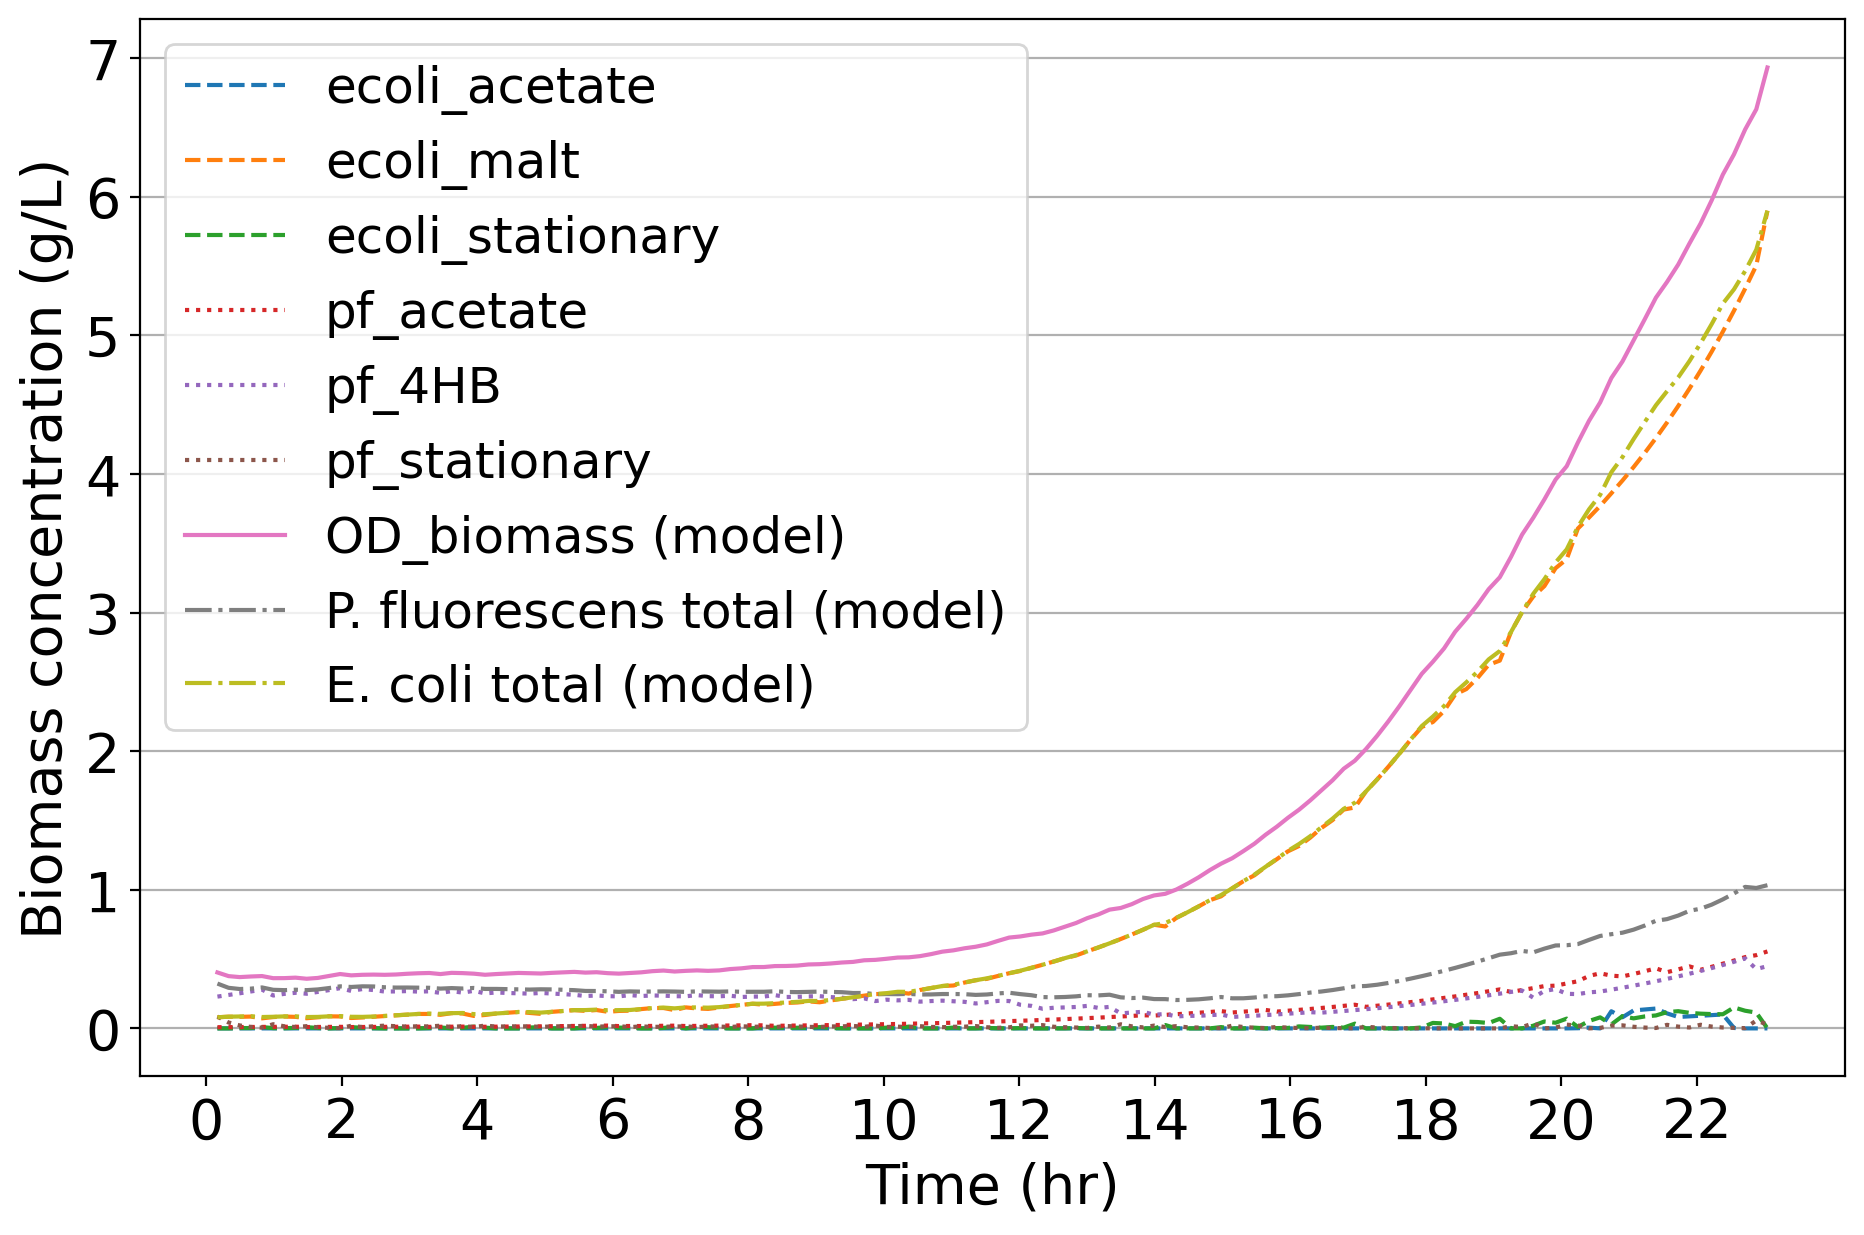

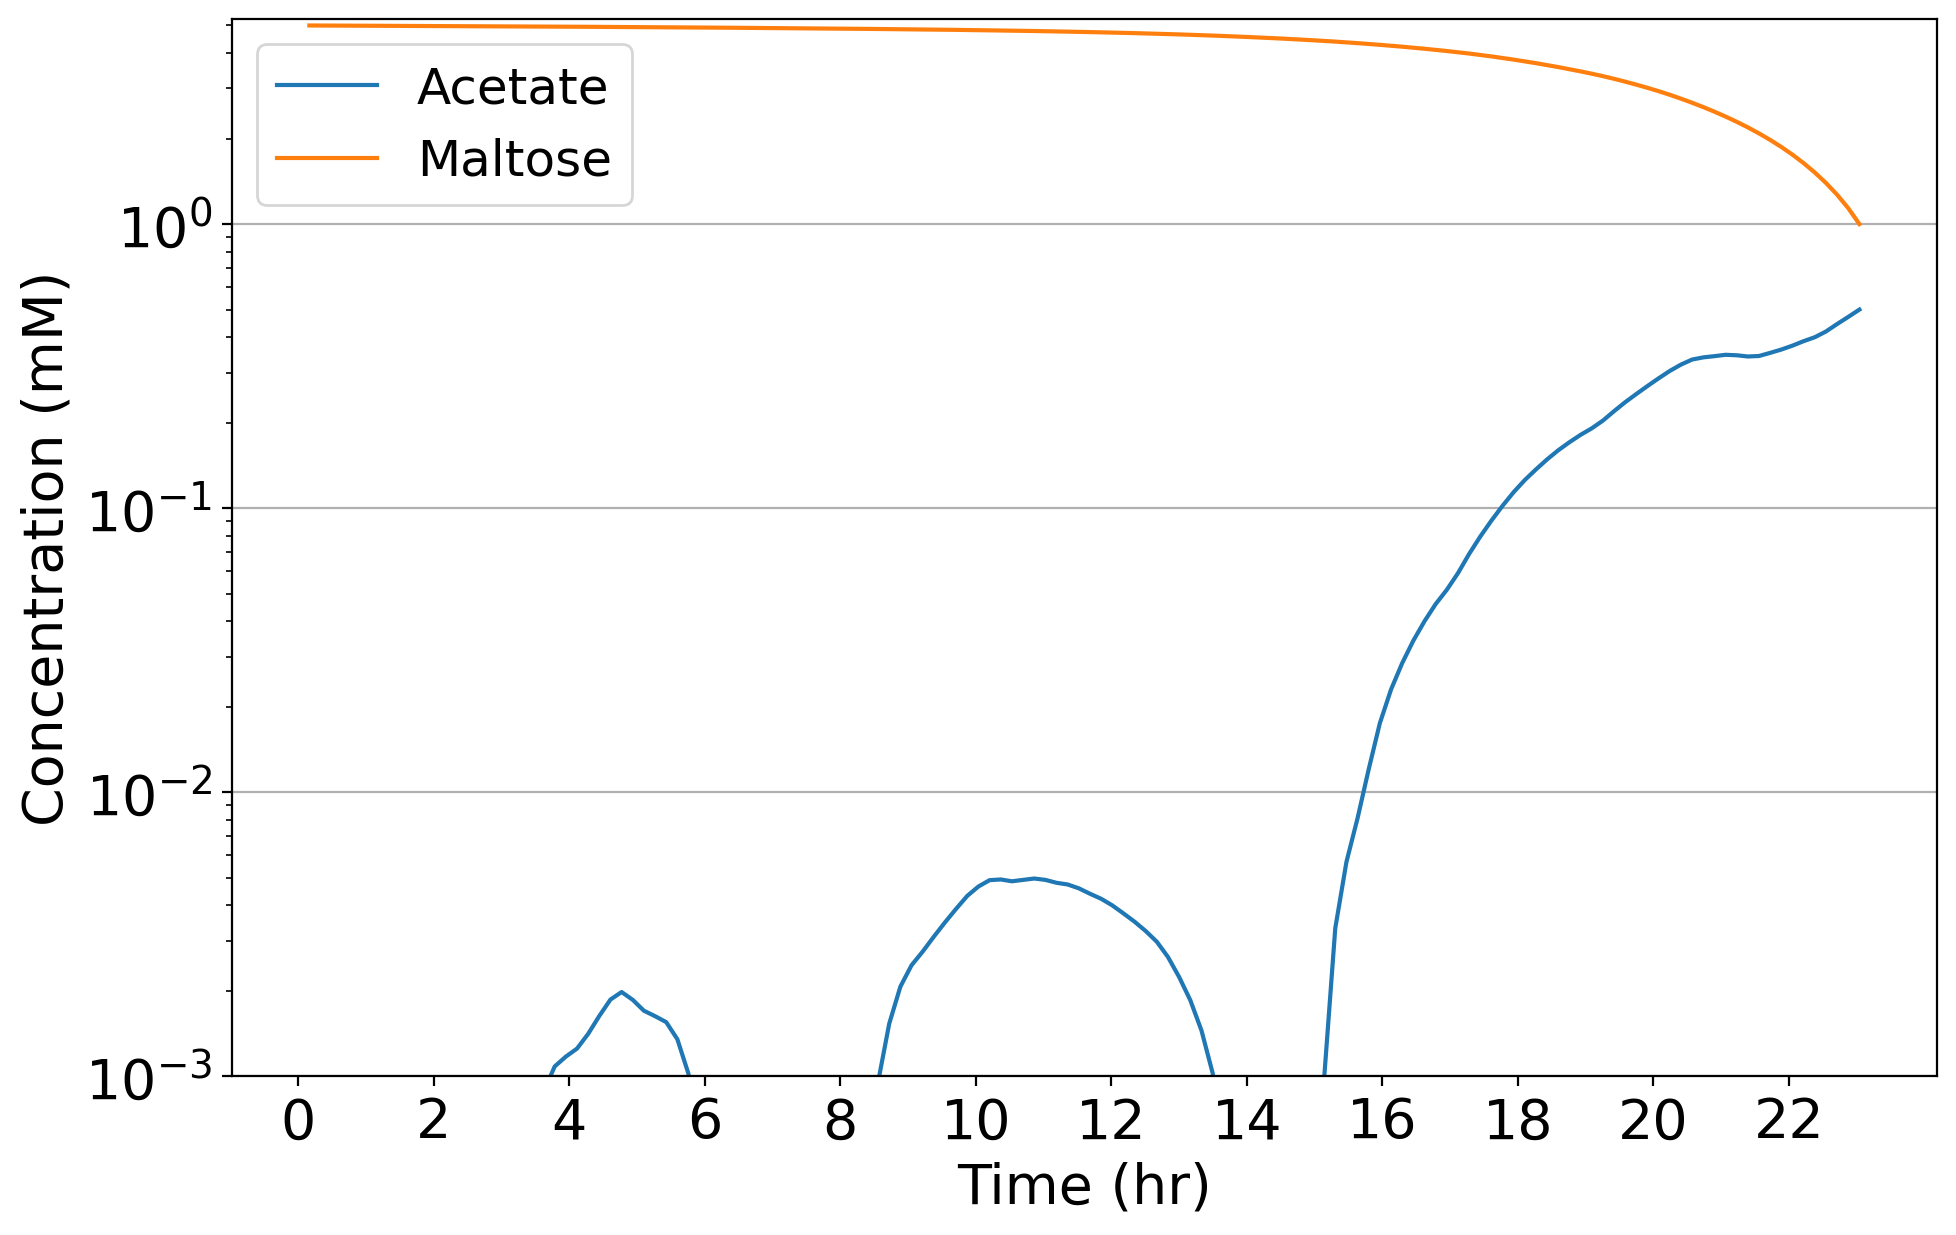

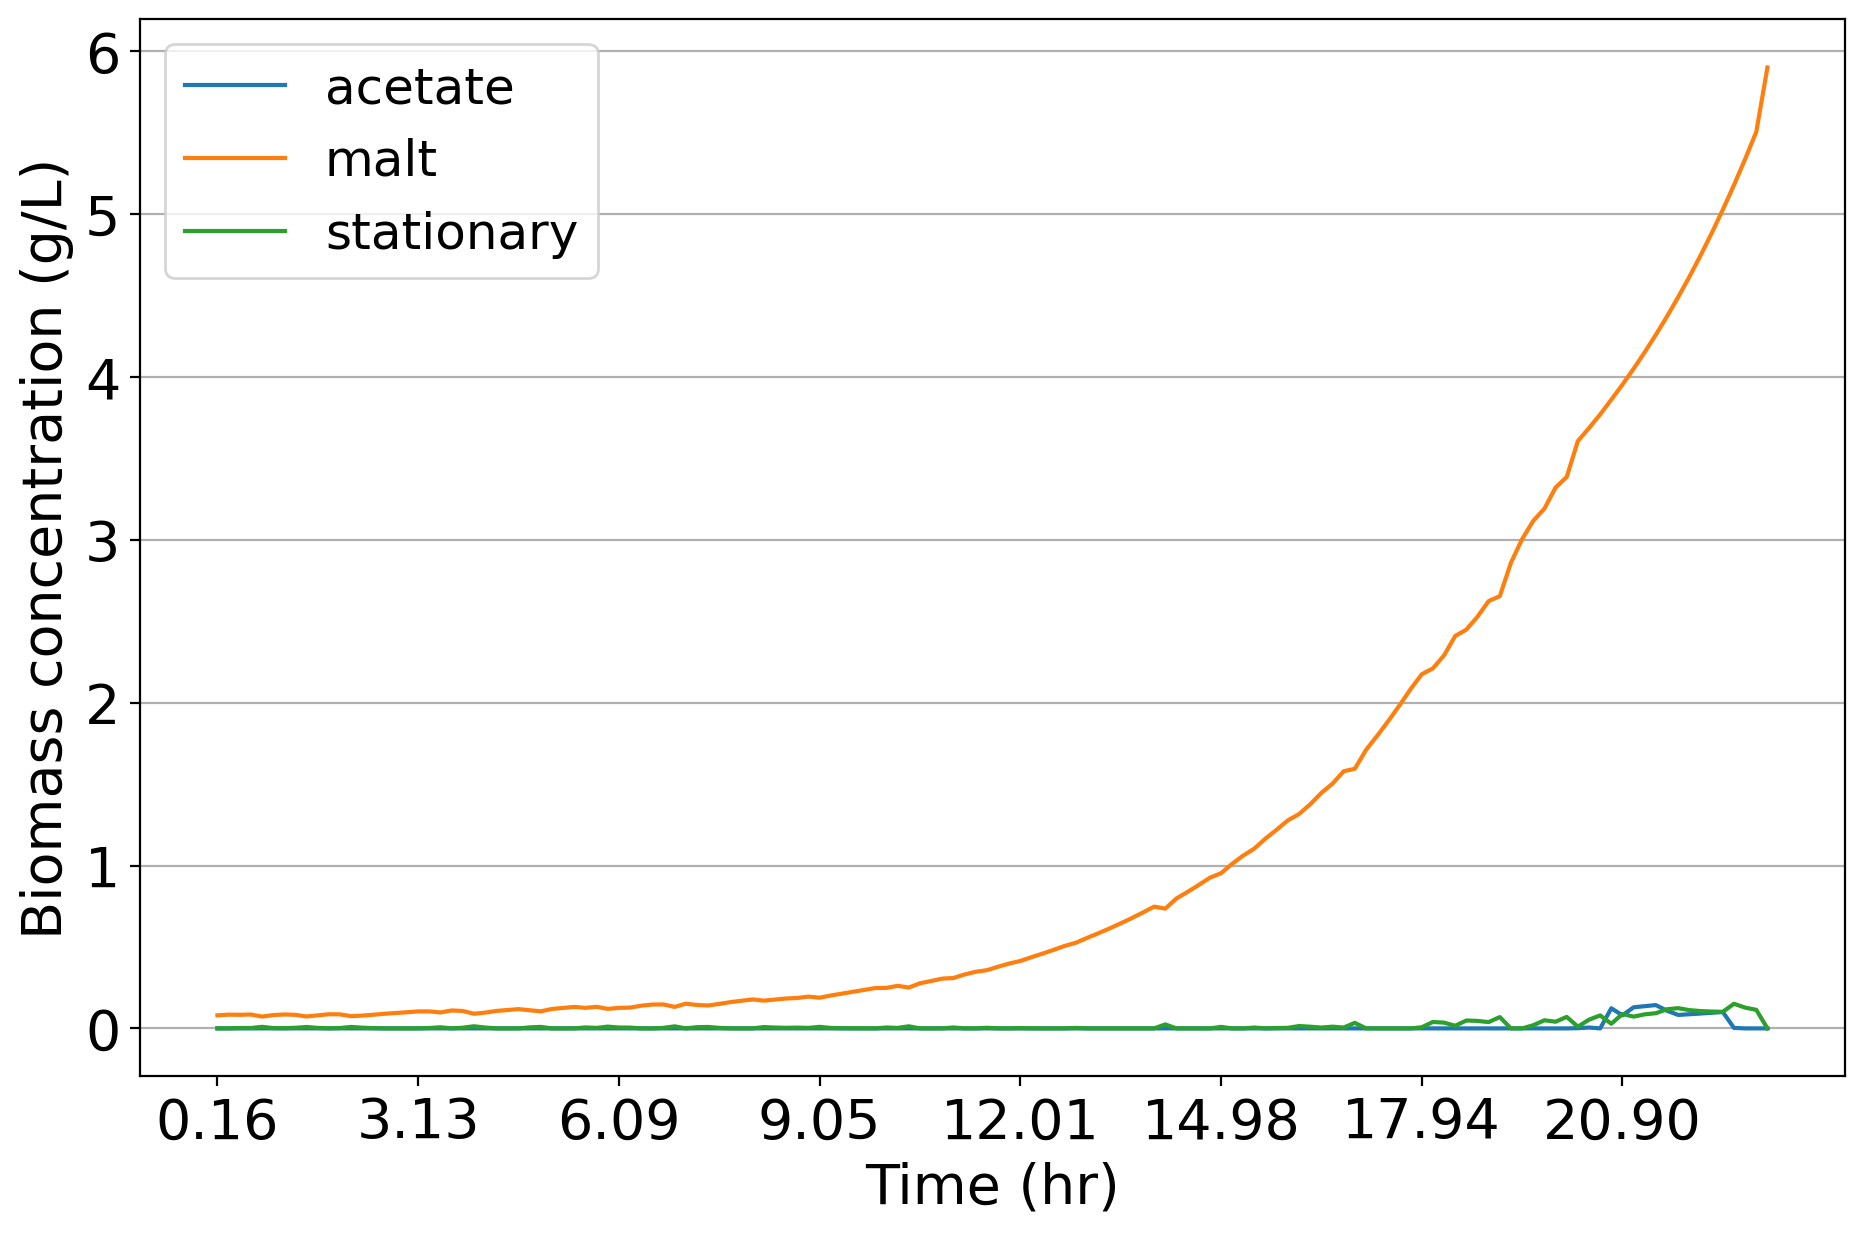

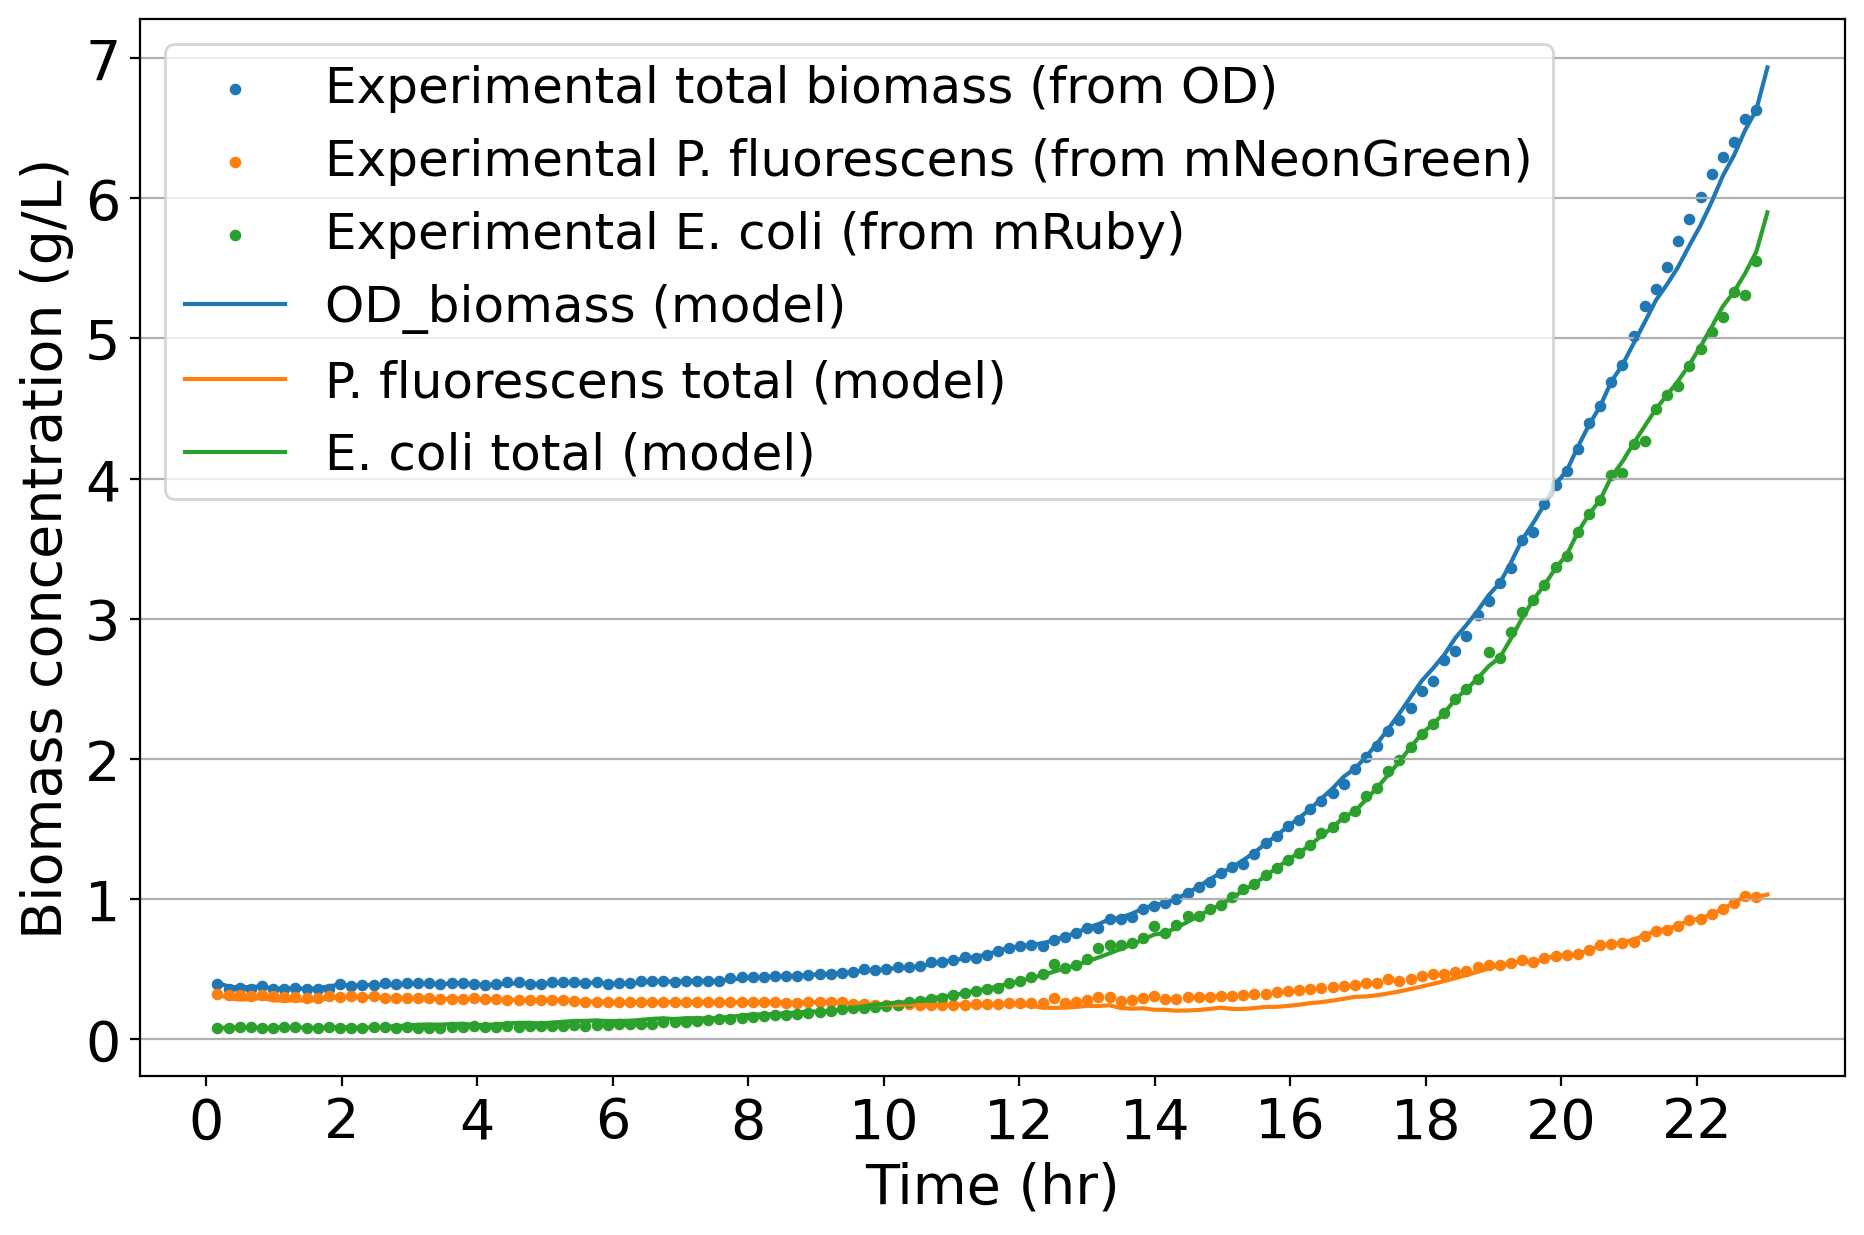

In [10]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, signal_species, species_phenos_df, growth_df, experimental_metadata)
maltose_4HB_commfit.fit(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     # export_zip_name='for_michaelis_menten.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    publishing=True)

In [5]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, signal_species, species_phenos_df, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     # export_zip_name='for_michaelis_menten.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    publishing=True)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:79: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.0013020833333333333 min
Done with DCC loop: 0.00026041666666666666 min
Done with the dbc & diffc loop: 0.002864583333333333 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.09166666666666666 min
Done exporting the content: 0.01484375 min

First kinetics optimization phase, iteration: 1
Done with concentrations and biomass loops: 0.0013020833333333333 min
Done with DCC loop: 0.00026041666666666666 min
Done with the dbc & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08541666666666667 min
Done exporting the content: 0.01171875 min
The solution is sub-optimal, with a(n) infeasible status.


ValueError: The kinetic optimization immediately failed with the first optimized biomasses.